# 0. Setup

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import itertools
import glob
import util
import pickle
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from scipy.ndimage import morphology
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

In [78]:
# Mount drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [79]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May  3 23:07:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    39W / 300W |  15729MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [80]:
DATASET_DIR = '../gdrive/MyDrive/projectdata/'
DATASET_DIR2 = '../gdrive/MyDrive/projectdata/dataset2/'
TF_DATASET_DIR = DATASET_DIR + 'dataset2/'
TUMOR_PATCH_DIR0 = DATASET_DIR2 + 'tumor_level0/'
TUMOR_PATCH_DIR1 = DATASET_DIR2 + 'tumor_level1/'
TUMOR_PATCH_DIR2 = DATASET_DIR2 + 'tumor_level2/'
TUMOR_PATCH_DIR3 = DATASET_DIR2 + 'tumor_level3/'
NORMAL_PATCH_DIR0 = DATASET_DIR2 + 'normal_level0/'
NORMAL_PATCH_DIR1 = DATASET_DIR2 + 'normal_level1/'
NORMAL_PATCH_DIR2 = DATASET_DIR2 + 'normal_level2/'
NORMAL_PATCH_DIR3 = DATASET_DIR2 + 'normal_level3/'

In [ ]:
util.make_directory_if_not_exist(DATASET_DIR)
util.make_directory_if_not_exist(DATASET_DIR2)
util.make_directory_if_not_exist(TUMOR_PATCH_DIR0)
util.make_directory_if_not_exist(TUMOR_PATCH_DIR1)
util.make_directory_if_not_exist(TUMOR_PATCH_DIR2)
util.make_directory_if_not_exist(TUMOR_PATCH_DIR3)
util.make_directory_if_not_exist(NORMAL_PATCH_DIR0)
util.make_directory_if_not_exist(NORMAL_PATCH_DIR1)
util.make_directory_if_not_exist(NORMAL_PATCH_DIR2)
util.make_directory_if_not_exist(NORMAL_PATCH_DIR3)
util.make_directory_if_not_exist(TF_DATASET_DIR)

# 1. Visualize Sample Data

Note: I relabel the data to be from 001 to 021

## 1.1 Inspect a sample slide

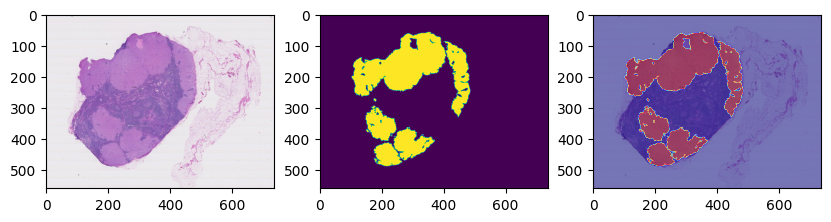

In [ ]:
slide_path = DATASET_DIR + 'tumor_021.tif'
tumor_mask_path = DATASET_DIR + 'tumor_021_mask.tif'
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)
slide_image = util.read_slide(slide, 
                         x=0, 
                         y=0,
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

mask_image = util.read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])[:,:,0]


fig, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=100)
ax[0].imshow(slide_image)
ax[1].imshow(mask_image)
ax[2].imshow(slide_image)
ax[2].imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
#plt.gca().grid(False)

## 1.2 Display Sample Mask Effect

In [ ]:
tumor_pixels =  util.find_tumor_pixels(mask_image)
tissue_pixels = util.find_tissue_pixels(slide_image)
combined_pixels,D = util.find_combined_pixels(tissue_pixels,tumor_pixels)

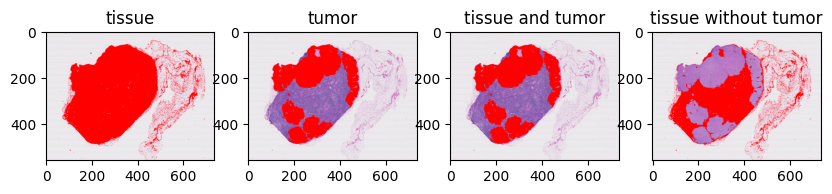

In [ ]:
tissue_regions = util.apply_mask(slide_image, tissue_pixels)
tumor_regions = util.apply_mask(slide_image, tumor_pixels)
combined_regions = util.apply_mask(slide_image, combined_pixels)
D_regions = util.apply_mask(slide_image, D)

fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=100)
ax[0].imshow(tissue_regions)
ax[0].set_title('tissue')

ax[1].imshow(tumor_regions)
ax[1].set_title('tumor')

ax[2].imshow(combined_regions)
ax[2].set_title('tissue and tumor')

ax[3].imshow(D_regions)
ax[3].set_title('tissue without tumor')
plt.gca().grid(False)

## 1.3 Display Image (different zoom levels) at One Center

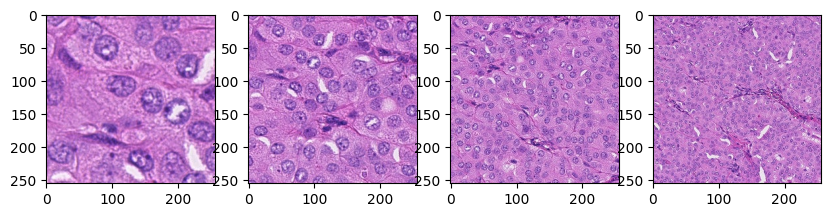

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=100)
ax[0].imshow(util.generate_level_image(8, tumor_mask, slide, window_size=256,base_level=0,random_num=1001))
ax[1].imshow(util.generate_level_image(8,tumor_mask,slide, window_size=256,base_level=1,random_num=1001))
ax[2].imshow(util.generate_level_image(8,tumor_mask,slide, 256,base_level=2,random_num=1001))
ax[3].imshow(util.generate_level_image(8,tumor_mask,slide, 256,base_level=3,random_num=1001))
plt.gca().grid(False)

# 2. Build TF Dataset

## 2.1 Tissue vs Tumor Dataset

In [ ]:
DATASET_DIR2 = '../gdrive/MyDrive/projectdata/dataset2/'

In [ ]:
util.prepare_normal_tissue_data(level=4,sample_size=160,window_size=256,range_size=22,base_levels=[0,1,2,3])

In [ ]:
util.prepare_tumor_tissue_data(level=4,sample_size=160,window_size=256,range_size=22,base_levels=[0,1,2,3])

## 2.2 Build the TF Dataset

In [ ]:
tumor_list0 = glob.glob(TUMOR_PATCH_DIR0+'*.png')
tumor_list1 = glob.glob(TUMOR_PATCH_DIR1+'*.png')
tumor_list2 = glob.glob(TUMOR_PATCH_DIR2+'*.png')
tumor_list3 = glob.glob(TUMOR_PATCH_DIR3+'*.png')

normal_list0 = glob.glob(NORMAL_PATCH_DIR0+'*.png')
normal_list1 = glob.glob(NORMAL_PATCH_DIR1+'*.png')
normal_list2 = glob.glob(NORMAL_PATCH_DIR2+'*.png')
normal_list3 = glob.glob(NORMAL_PATCH_DIR3+'*.png')

In [ ]:
path_list0, labels0 = util.build_tf_data(normal_list0,tumor_list0)
path_list1, labels1 = util.build_tf_data(normal_list1,tumor_list1)
path_list2, labels2 = util.build_tf_data(normal_list2,tumor_list2)
path_list3, labels3 = util.build_tf_data(normal_list3,tumor_list3)

In [ ]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(path_list0, 
                                                    labels0, 
                                                    test_size=0.20, 
                                                    random_state=51, 
                                                    shuffle=True)
X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, 
                                                  y_train0, 
                                                  test_size=0.20, 
                                                  random_state=51, 
                                                  shuffle=True)


X_train1, X_test1, y_train1, y_test1 = train_test_split(path_list1, 
                                                    labels1, 
                                                    test_size=0.20, 
                                                    random_state=51, 
                                                    shuffle=True)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, 
                                                  y_train1, 
                                                  test_size=0.20, 
                                                  random_state=51, 
                                                  shuffle=True)


X_train2, X_test2, y_train2, y_test2 = train_test_split(path_list2, 
                                                    labels2, 
                                                    test_size=0.20, 
                                                    random_state=51, 
                                                    shuffle=True)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, 
                                                  y_train2, 
                                                  test_size=0.20, 
                                                  random_state=51, 
                                                  shuffle=True)



X_train3, X_test3, y_train3, y_test3 = train_test_split(path_list3, 
                                                    labels3, 
                                                    test_size=0.20, 
                                                    random_state=51, 
                                                    shuffle=True)

X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, 
                                                  y_train3, 
                                                  test_size=0.20, 
                                                  random_state=51, 
                                                  shuffle=True)

## 2.3 Save Dataset to Drive 

In [ ]:
np.save(TF_DATASET_DIR+'y_train0', y_train0)
np.save(TF_DATASET_DIR+'y_val0', y_val0)
np.save(TF_DATASET_DIR+'y_test0', y_test0)

np.save(TF_DATASET_DIR+'y_train1', y_train1)
np.save(TF_DATASET_DIR+'y_val1', y_val1)
np.save(TF_DATASET_DIR+'y_test1', y_test1)

np.save(TF_DATASET_DIR+'y_train2', y_train2)
np.save(TF_DATASET_DIR+'y_val2', y_val2)
np.save(TF_DATASET_DIR+'y_test2', y_test2)

np.save(TF_DATASET_DIR+'y_train3', y_train3)
np.save(TF_DATASET_DIR+'y_val3', y_val3)
np.save(TF_DATASET_DIR+'y_test3', y_test3)

In [ ]:
X_ds_train0 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_train0, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_train0.tfrec')
tfrec.write(X_ds_train0)
X_ds_train1 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_train1, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_train1.tfrec')
tfrec.write(X_ds_train1)
X_ds_train2 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_train2, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_train2.tfrec')
tfrec.write(X_ds_train2)
X_ds_train3 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_train3, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_train3.tfrec')
tfrec.write(X_ds_train3)

In [ ]:
X_ds_val0 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_val0, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(
    TF_DATASET_DIR+'X_val0.tfrec')
tfrec.write(X_ds_val0)
X_ds_val1 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_val1, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(
    TF_DATASET_DIR+'X_val1.tfrec')
tfrec.write(X_ds_val1)
X_ds_val2 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_val2, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(
    TF_DATASET_DIR+'X_val2.tfrec')
tfrec.write(X_ds_val2)
X_ds_val3 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_val3, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(
    TF_DATASET_DIR+'X_val3.tfrec')
tfrec.write(X_ds_val3)

In [ ]:
X_ds_test0 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_test0, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_test0.tfrec')
tfrec.write(X_ds_test0)

X_ds_test1 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_test1, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_test1.tfrec')
tfrec.write(X_ds_test1)

X_ds_test2 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_test2, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_test2.tfrec')
tfrec.write(X_ds_test2)

X_ds_test3 = tf.data.Dataset.from_tensor_slices(
    tf.cast(X_test3, tf.string)).map(util._parse_function).map(tf.io.serialize_tensor)
tfrec = tf.data.experimental.TFRecordWriter(TF_DATASET_DIR+'X_test3.tfrec')
tfrec.write(X_ds_test3)

## 2.4 Load TF dataset

In [84]:
y_train0 = np.load(TF_DATASET_DIR+'y_train0.npy')
y_train1 = np.load(TF_DATASET_DIR+'y_train1.npy')
y_train2 = np.load(TF_DATASET_DIR+'y_train2.npy')
y_train3 = np.load(TF_DATASET_DIR+'y_train3.npy')

In [85]:
y_ds_train0 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_train0, tf.int64))
y_ds_train1 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_train1, tf.int64))
y_ds_train2 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_train2, tf.int64))
y_ds_train3 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_train3, tf.int64))

In [86]:
y_val0 = np.load(TF_DATASET_DIR+'y_val0.npy')
y_ds_val0 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_val0, tf.int64))
y_val1 = np.load(TF_DATASET_DIR+'y_val1.npy')
y_ds_val1 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_val1, tf.int64))
y_val2 = np.load(TF_DATASET_DIR+'y_val2.npy')
y_ds_val2 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_val2, tf.int64))
y_val3 = np.load(TF_DATASET_DIR+'y_val3.npy')
y_ds_val3 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_val3, tf.int64))

In [87]:
y_test0 = np.load(TF_DATASET_DIR+'y_test0.npy')
y_ds_test0 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_test0, tf.int64))

y_test1 = np.load(TF_DATASET_DIR+'y_test1.npy')
y_ds_test1 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_test1, tf.int64))

y_test2 = np.load(TF_DATASET_DIR+'y_test2.npy')
y_ds_test2 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_test2, tf.int64))

y_test3 = np.load(TF_DATASET_DIR+'y_test3.npy')
y_ds_test3 = tf.data.Dataset.from_tensor_slices(
    tf.cast(y_test3, tf.int64))

In [88]:
X_ds_train0 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_train0.tfrec').map(
    util.augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_train1 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_train1.tfrec').map(
    util.augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_train2 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_train2.tfrec').map(
    util.augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_train3 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_train3.tfrec').map(
    util.augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [89]:
X_ds_val0 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_val0.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_val1 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_val1.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_val2 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_val2.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_val3 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_val3.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [90]:
X_ds_test0 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_test0.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_test1 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_test1.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_test2 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_test2.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

X_ds_test3 = tf.data.TFRecordDataset(TF_DATASET_DIR+'X_test3.tfrec').map(
    util.read_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# 3. Training

## 3.1 Visulize Sample Training Data

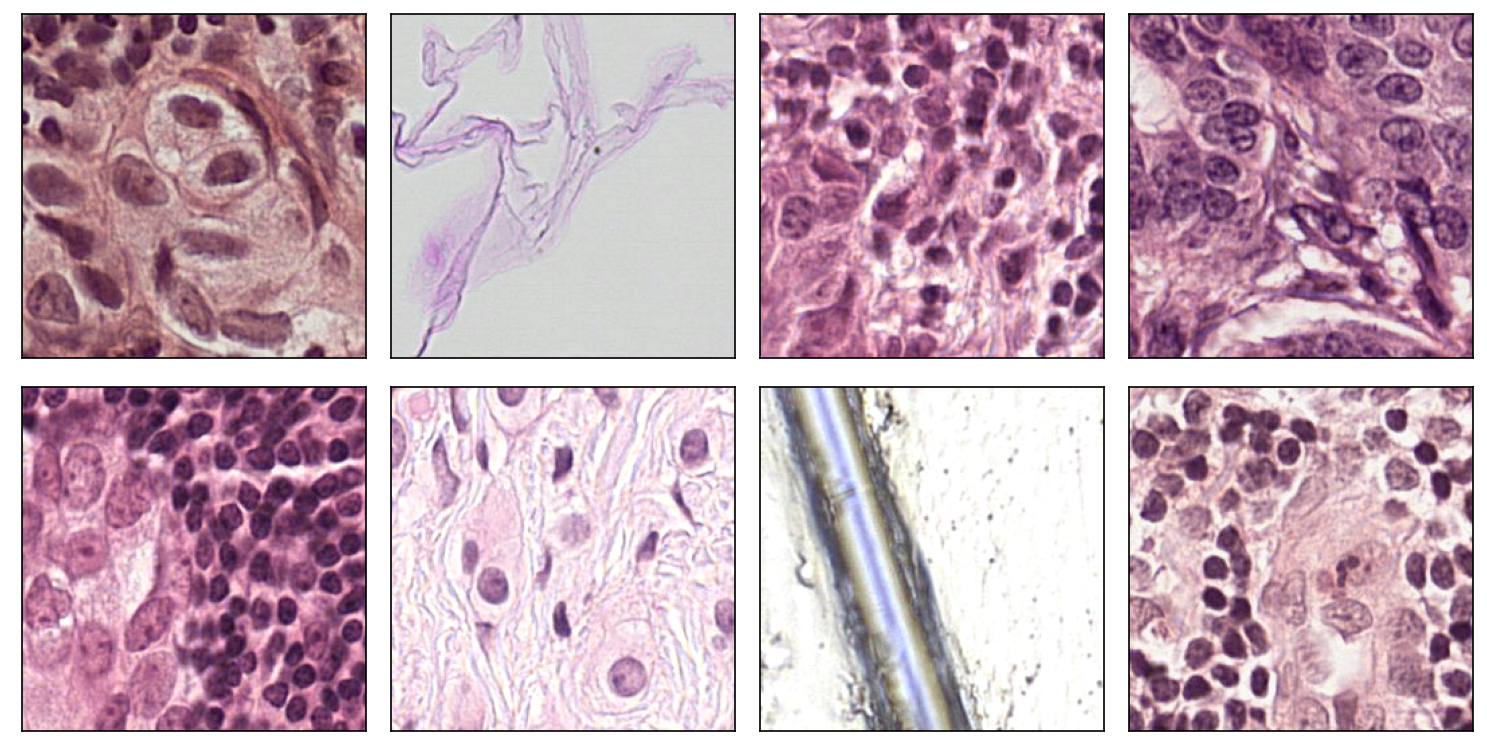

In [ ]:
util.vis_sample(y_ds_train0,X_ds_train0)

In [ ]:
BATCH_SIZE = 256
ds_train = tf.data.Dataset.zip(
    ((X_ds_train0,X_ds_train1,X_ds_train2,X_ds_train3), y_ds_train0)).apply(tf.data.experimental.shuffle_and_repeat(128)).batch(
    BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

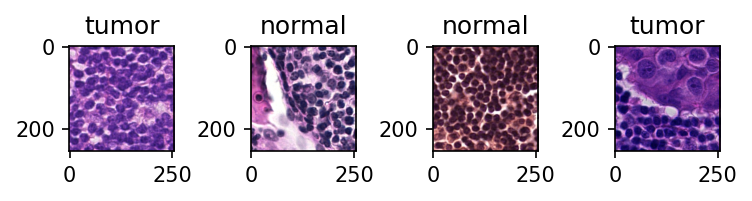

In [ ]:
util.vis_patch(ds_train)

## 3.2 Define the Baseline InceptionV3 model

In [ ]:
conv_base = InceptionV3(include_top=False, weights='imagenet',input_shape=(256, 256, 3))
for layer in conv_base.layers:
    layer.trainable = False

model_base = Sequential()
model_base.add(conv_base)
model_base.add(Flatten())
model_base.add(Dense(256, activation='softmax'))
model_base.add(tf.keras.layers.Dropout(0.2))
model_base.add(Dense(256, activation='softmax'))
model_base.add(tf.keras.layers.Dropout(0.2))
model_base.add(Dense(1, activation='sigmoid'))

model_base.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'])

In [82]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               18874624  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

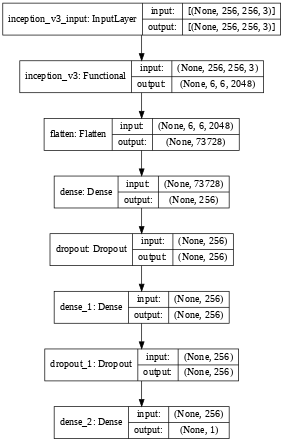

In [83]:
tf.keras.utils.plot_model(model_base, 'InceptionV3_Base.png', show_shapes=True,dpi=50)

In [92]:
BATCH_SIZE = 256
ds_train_base = tf.data.Dataset.zip(
    (X_ds_train1, y_ds_train1)).apply(tf.data.experimental.shuffle_and_repeat(128)).batch(
    BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [93]:
steps_per_epoch = 100
EPOCHS = 5
history_base = model_base.fit(ds_train_base,
                              epochs=EPOCHS,
                              steps_per_epoch=steps_per_epoch) 

Epoch 1/5
100/100 [==============================] - 79s 731ms/step - loss: 0.6922 - acc: 0.5639
Epoch 2/5
100/100 [==============================] - 72s 722ms/step - loss: 0.6839 - acc: 0.8047
Epoch 3/5
100/100 [==============================] - 73s 727ms/step - loss: 0.6615 - acc: 0.8173
Epoch 4/5
100/100 [==============================] - 72s 721ms/step - loss: 0.6300 - acc: 0.8055
Epoch 5/5
100/100 [==============================] - 70s 703ms/step - loss: 0.5882 - acc: 0.8265


In [95]:
ds_val_base = X_ds_val1.batch(256, drop_remainder=False).prefetch(
    tf.data.experimental.AUTOTUNE)
y_pred_base = model_base.predict(ds_val_base,verbose=1)

4/4 [==============================] - 8s 2s/step


In [96]:
util.plot_confusion_matrix(y_val1, y_pred_base > 0.5, 
                           classes=['normal', 'tumor'],
                           normalize=True,
                           title_prefix="",
                           cmap=plt.cm.Blues)

confusion_raw:
 [[427  63]
 [ 62 452]]


## 3.3 Define the InceptionV3 model with Four Inputs

In [ ]:
Input_a = Input(shape=(256, 256, 3))
Input_b = Input(shape=(256, 256, 3))
Input_c = Input(shape=(256, 256, 3))
Input_d = Input(shape=(256, 256, 3))

conv_base1 = InceptionV3(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

for layer in conv_base1.layers:
    layer.trainable = False

conv_base2 = InceptionV3(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

for layer in conv_base2.layers:
    layer.trainable = False

conv_base3 = InceptionV3(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

for layer in conv_base3.layers:
    layer.trainable = False

conv_base4 = InceptionV3(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

for layer in conv_base4.layers:
    layer.trainable = False

model1 = Sequential()
model1.add(conv_base1)
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(32, activation='softmax'))

model2 = Sequential()
model2.add(conv_base2)
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(32, activation='softmax'))

model3 = Sequential()
model3.add(conv_base3)
model3.add(MaxPooling2D())
model3.add(Flatten())
model3.add(Dense(32, activation='softmax'))

model4 = Sequential()
model4.add(conv_base4)
model4.add(MaxPooling2D())
model4.add(Flatten())
model4.add(Dense(32, activation='softmax'))

encoded_image1 = model1(Input_a)
encoded_image2 = model2(Input_b)
encoded_image3 = model3(Input_c)
encoded_image4 = model4(Input_d)


x = tf.keras.layers.concatenate([encoded_image1, encoded_image2,encoded_image3,encoded_image4], name='concat_test')
dropout = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout)
model = tf.keras.Model(inputs=[Input_a, Input_b,Input_c,Input_d], outputs=output)

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, 'InceptionV3_Four.png', show_shapes=True)

## 3.4 Train the Model

Note: I pretrain a few epochs

In [ ]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 1e-5)

In [ ]:
steps_per_epoch = 100
EPOCHS = 5
history = model.fit(ds_train,
                    epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch) 

Epoch 1/5
100/100 [==============================] - 305s 3s/step - loss: 0.0489 - acc: 0.9895
Epoch 2/5
100/100 [==============================] - 283s 3s/step - loss: 0.0508 - acc: 0.9883
Epoch 3/5
100/100 [==============================] - 289s 3s/step - loss: 0.0540 - acc: 0.9872
Epoch 4/5
100/100 [==============================] - 294s 3s/step - loss: 0.0574 - acc: 0.9867
Epoch 5/5
100/100 [==============================] - 292s 3s/step - loss: 0.0498 - acc: 0.9879


## 3.5 Save the Model

In [ ]:
pickle.dump(history.history,
            open(DATASET_DIR + "dataset2/model/model_Inception_V3_baseline_history_final.p", "wb" ))
model.save(DATASET_DIR + "dataset2/model/model_Inception_V3_baseline")

In [ ]:
pickle.dump(history.history,
            open(DATASET_DIR + "dataset2/model/model_Inception_V3_fourinputs_history_final.p", "wb" ))
model.save(DATASET_DIR + "dataset2/model/model_Inception_V3_fourinputs_final")

## 3.6 Plot the Training ACC

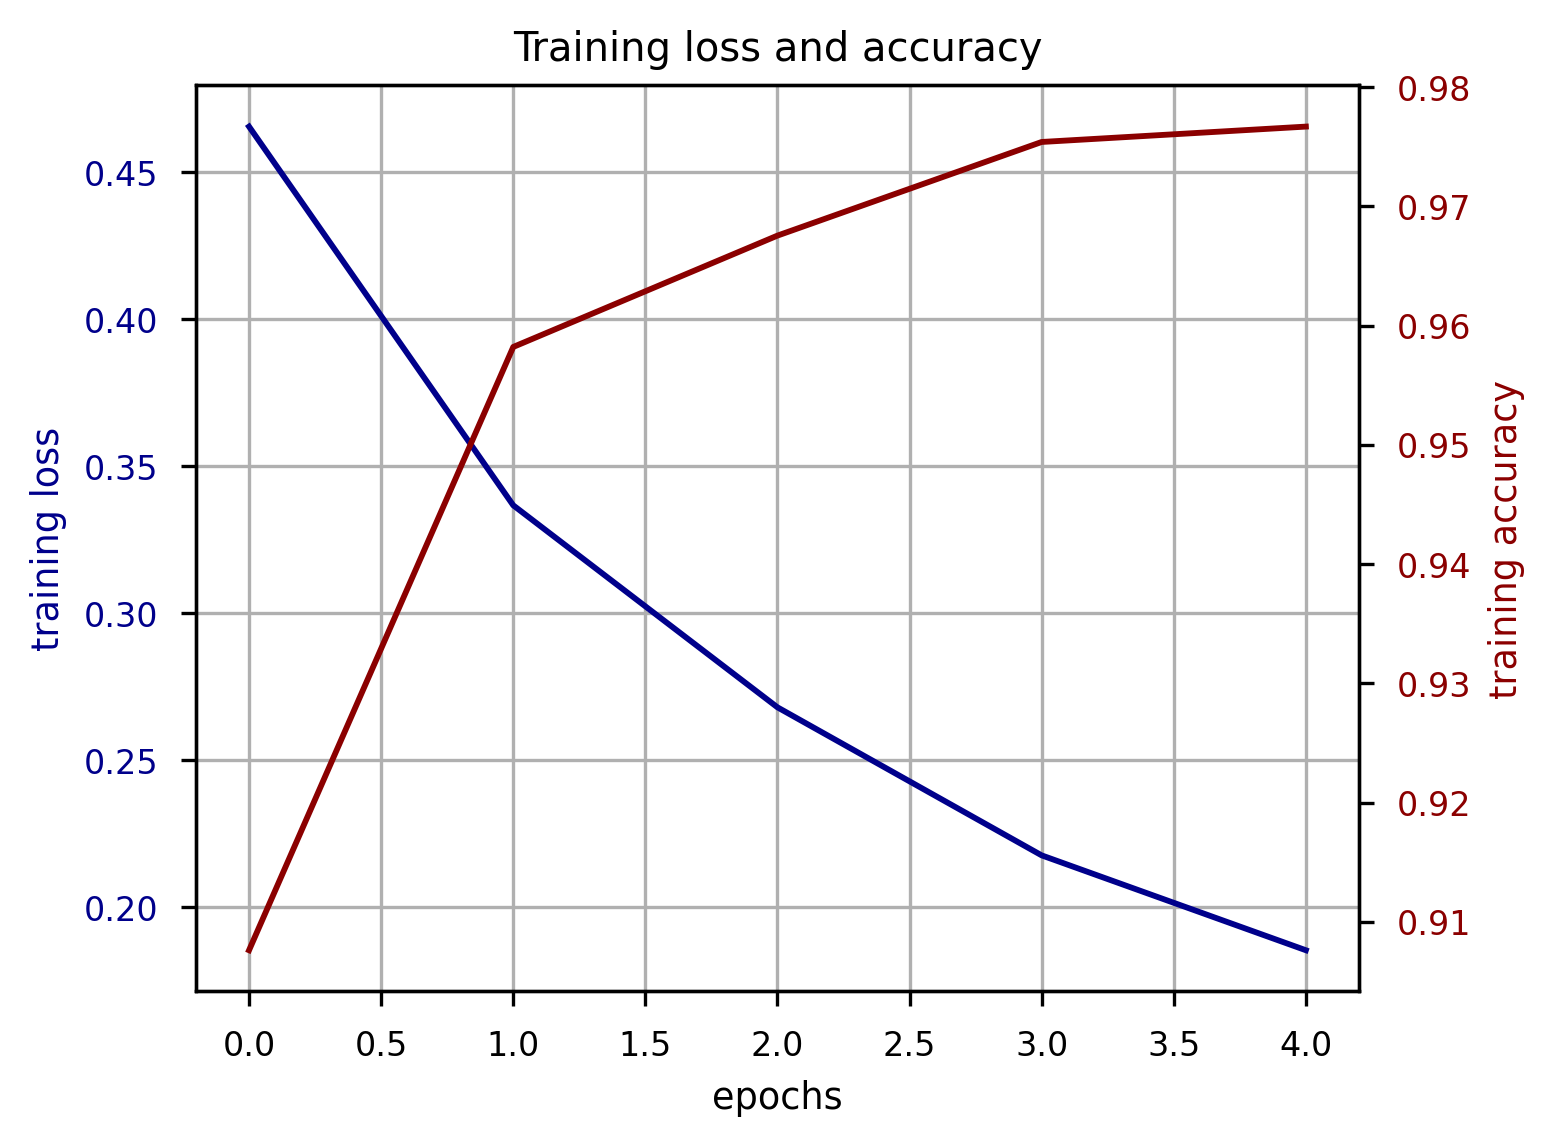

In [ ]:
util.plot_train(history.history)

# 4. Evaluation

## 4.1 Load Model and Test on Validation and Test Dataset

In [ ]:
model = tf.keras.models.load_model(DATASET_DIR + "dataset2/model/model_Inception_V3_fourinputs_final")

In [ ]:
ds_val = tf.data.Dataset.zip(((X_ds_val0, X_ds_val1,X_ds_val2,X_ds_val3), )).batch(256, drop_remainder=False).prefetch(
    tf.data.experimental.AUTOTUNE)
ds_val

<PrefetchDataset shapes: (((None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3)),), types: ((tf.float32, tf.float32, tf.float32, tf.float32),)>

In [ ]:
y_pred = model.predict(ds_val,verbose=1)

4/4 [==============================] - 47s 5s/step


confusion_raw:
 [[484   6]
 [ 66 448]]


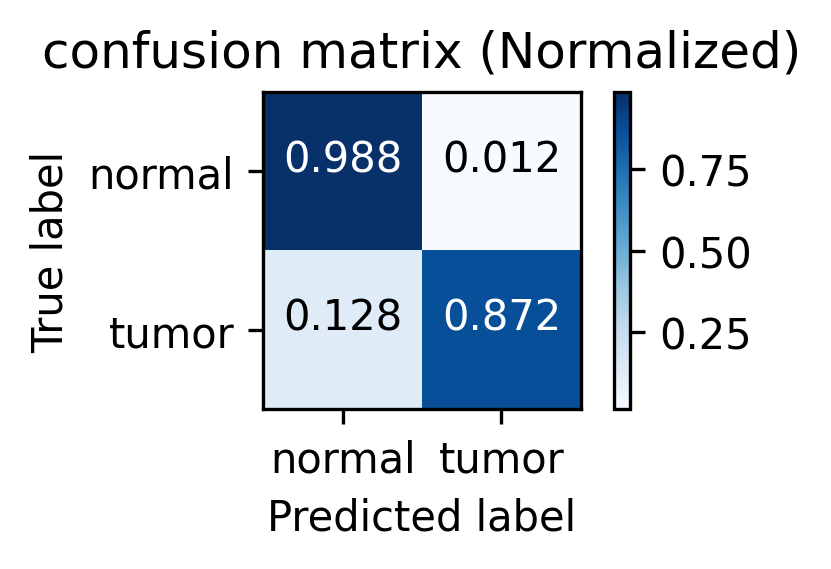

In [ ]:
util.plot_confusion_matrix(y_val0, y_pred > 0.5, 
                           classes=['normal', 'tumor'],
                           normalize=True,
                           title_prefix="",
                           cmap=plt.cm.Blues)

In [ ]:
ds_test = tf.data.Dataset.zip(((X_ds_test0, X_ds_test1,X_ds_test2,X_ds_test3), )).batch(256, drop_remainder=False).prefetch(
    tf.data.experimental.AUTOTUNE)
ds_test

<PrefetchDataset shapes: (((None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3), (None, 256, 256, 3)),), types: ((tf.float32, tf.float32, tf.float32, tf.float32),)>

In [ ]:
y_pred = model.predict(ds_test, verbose=1)

5/5 [==============================] - 24s 5s/step


confusion_raw:
 [[640  11]
 [ 75 529]]


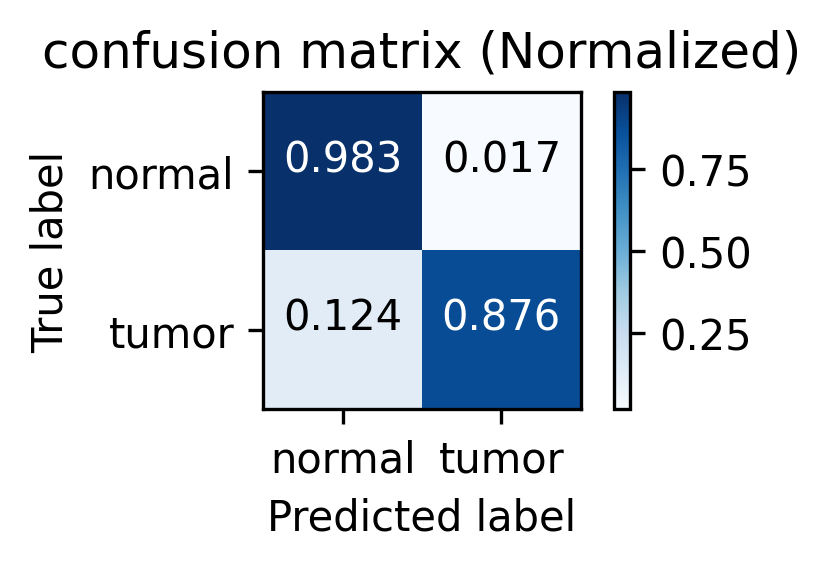

In [ ]:
util.plot_confusion_matrix(y_test0, y_pred > 0.5, 
                           classes=['normal', 'tumor'],
                           normalize=True,
                           title_prefix="",
                           cmap=plt.cm.Blues)

## 4.2 Plot Right and Wrong Classification

In [ ]:
ds_test = tf.data.Dataset.zip(((X_ds_test0, X_ds_test1,X_ds_test2,X_ds_test3), y_ds_test0)).batch(
        512, drop_remainder=False).prefetch(tf.data.experimental.AUTOTUNE)

2/2 [==============================] - 12s 826ms/step


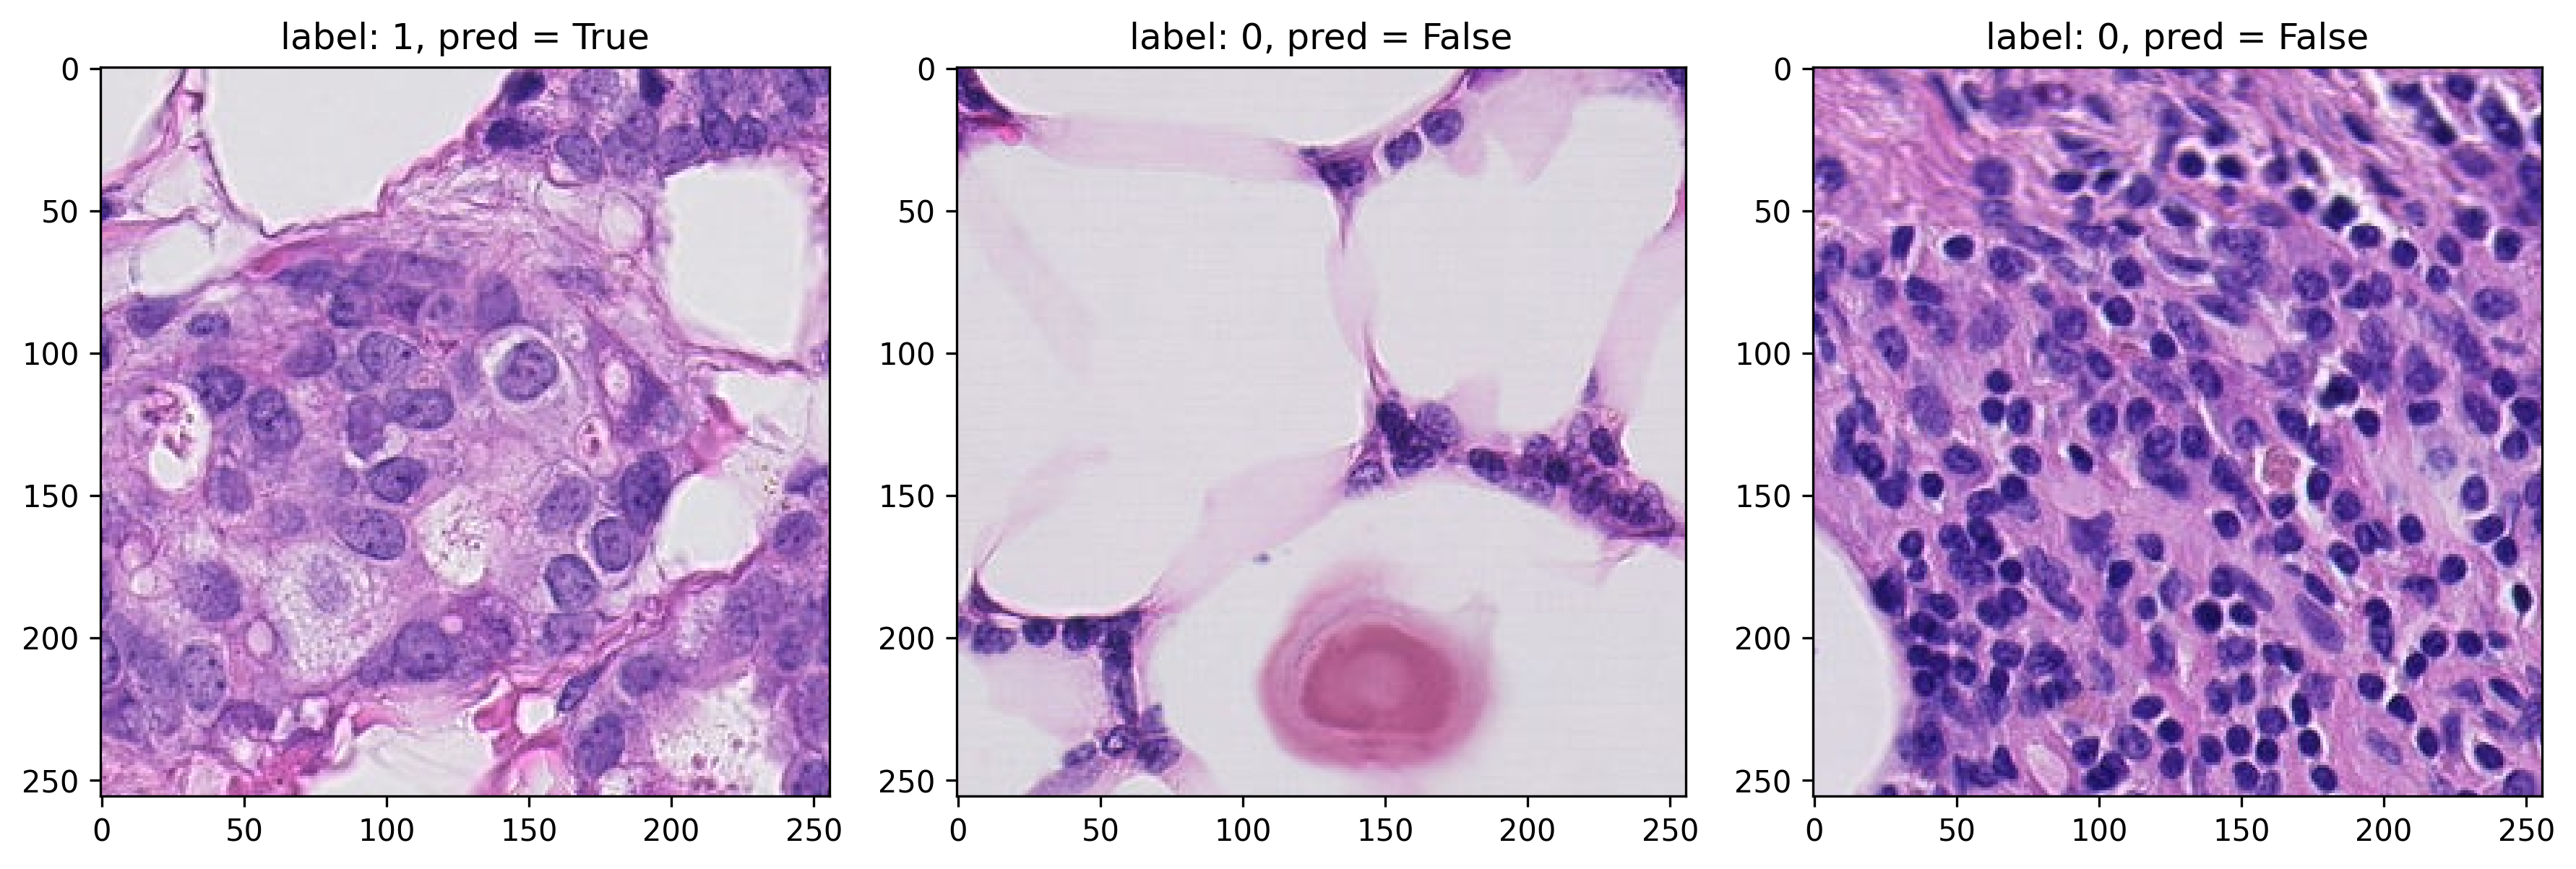

In [ ]:
util.display_right_cc(ds_test, model)

2/2 [==============================] - 11s 823ms/step


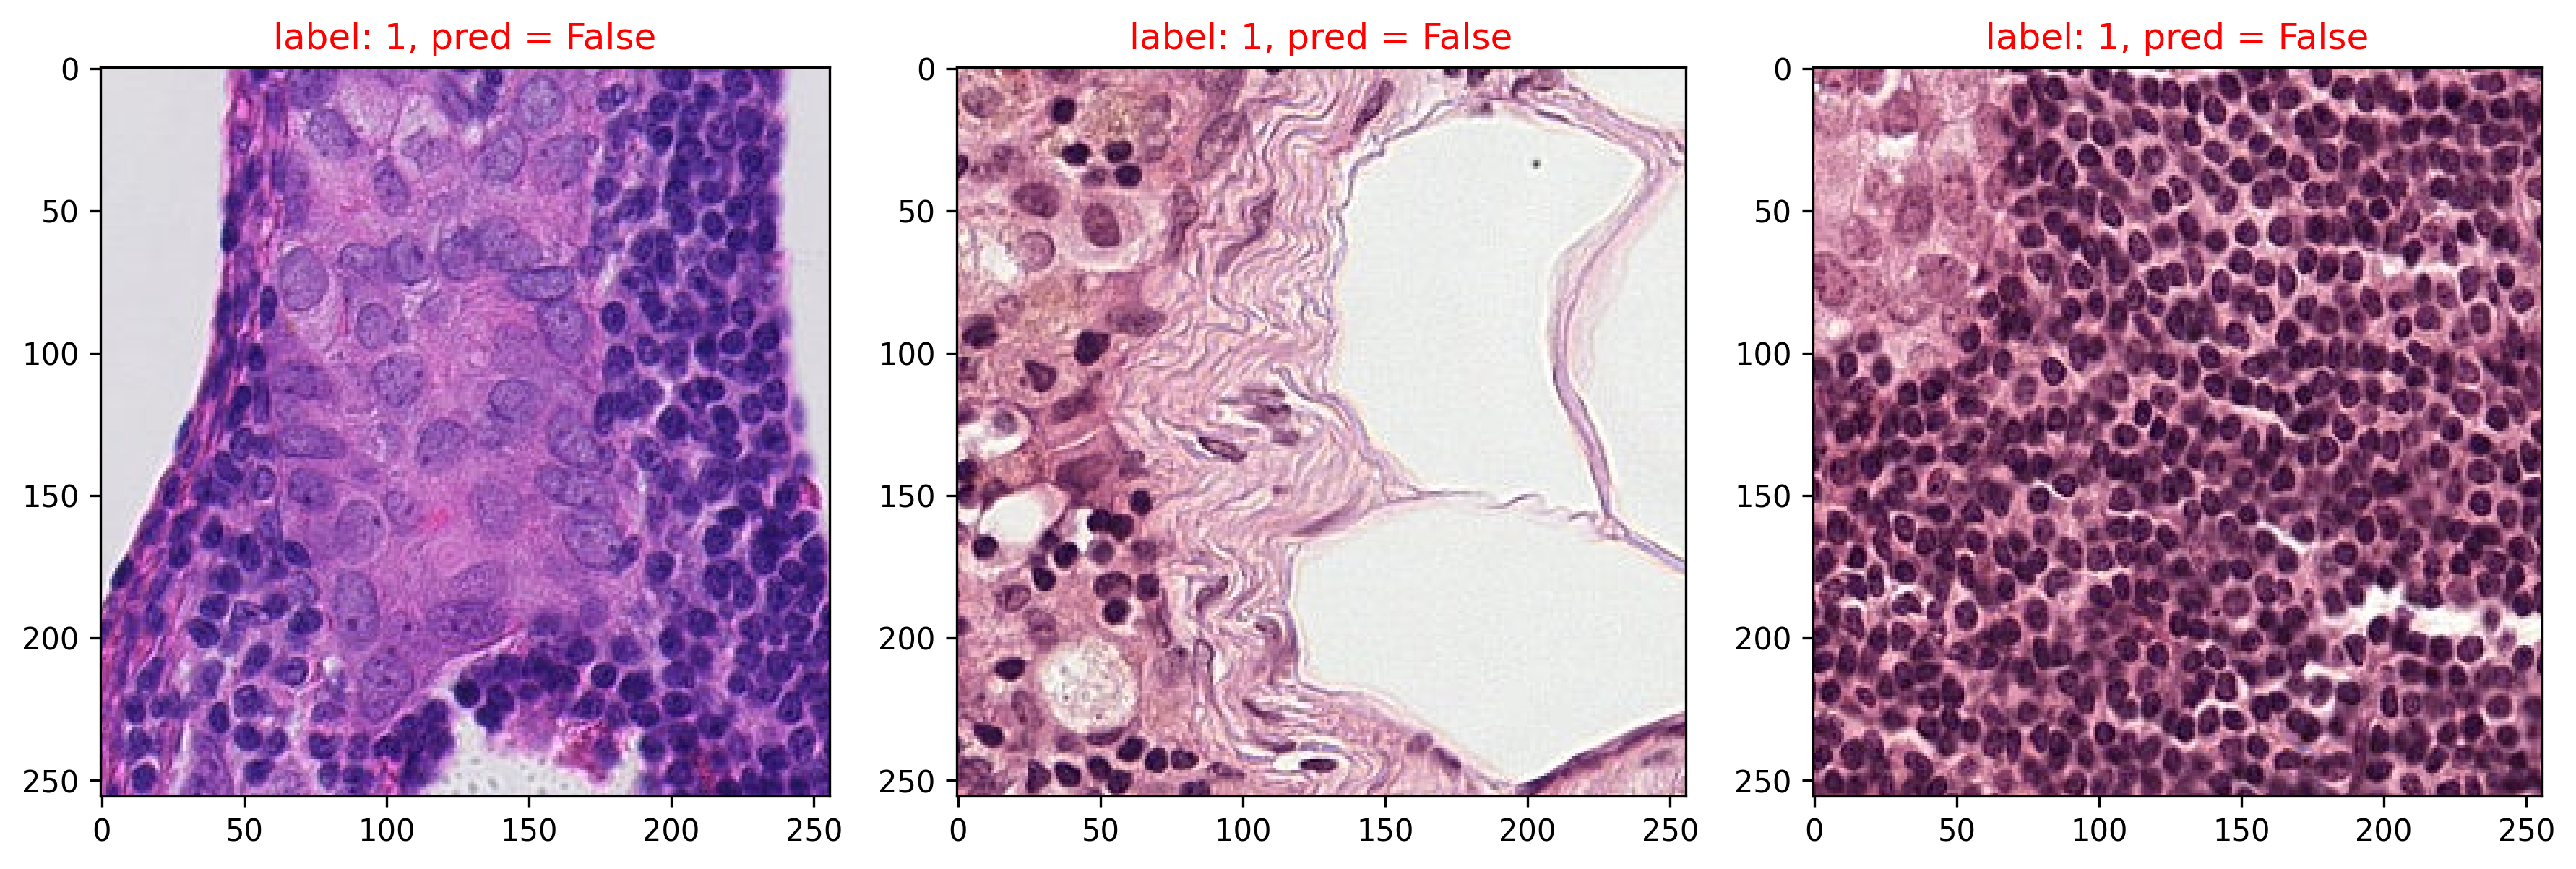

In [ ]:
util.display_wrong_cc(ds_test, model)

## 4.3 Test on a Old TIF

9


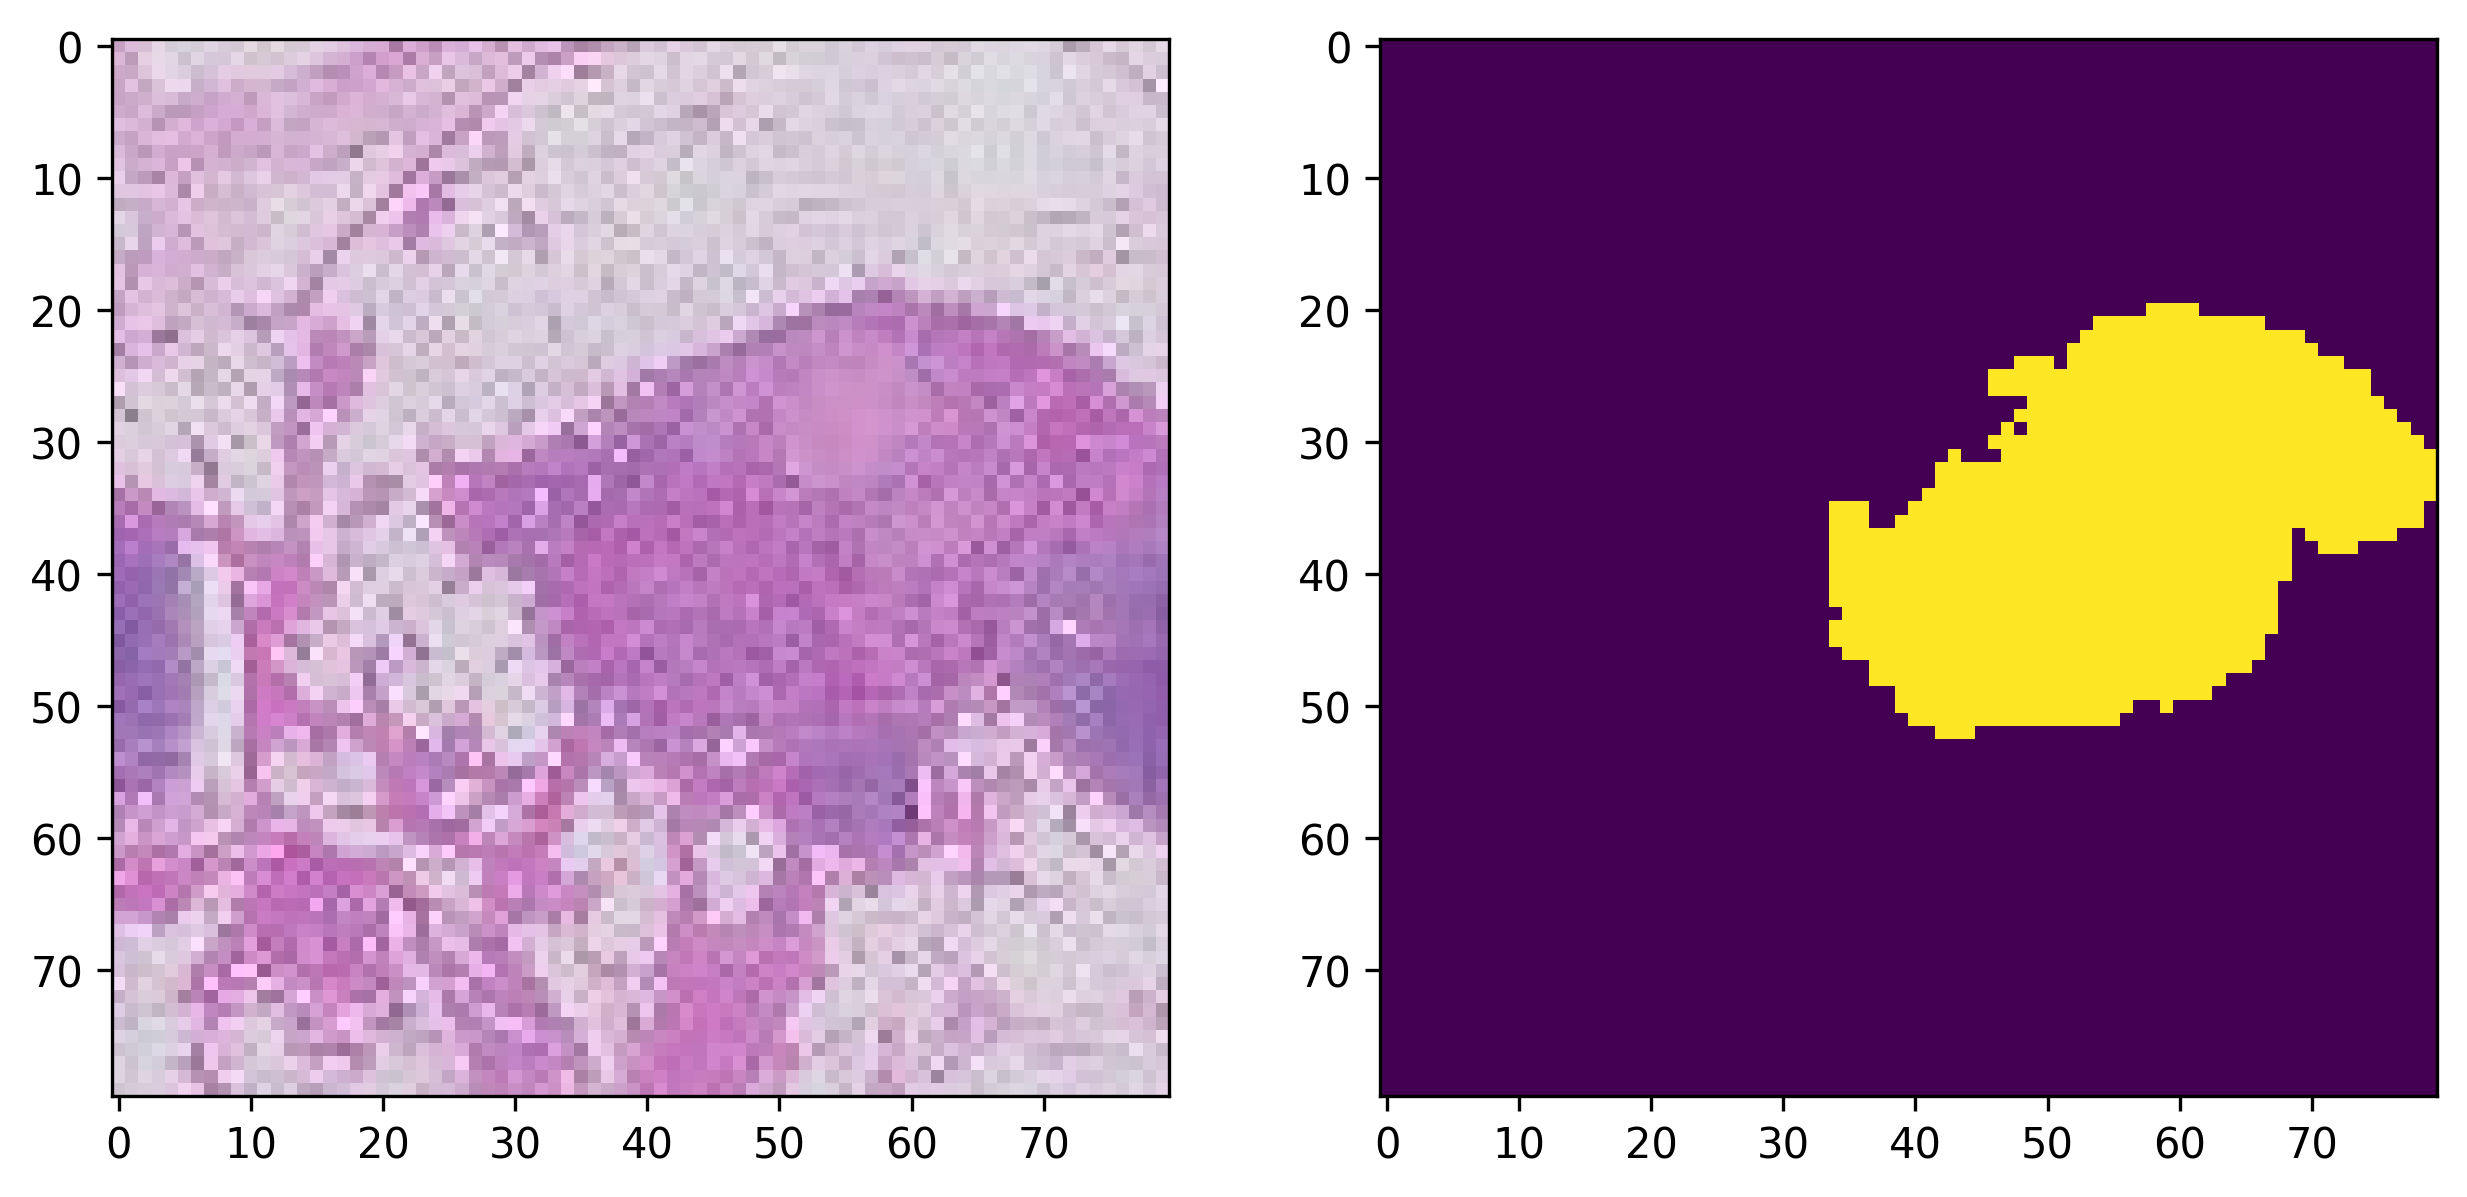

In [ ]:
slide_path = '../gdrive/MyDrive/projectdata/tumor_018.tif'
tumor_mask_path = "../gdrive/MyDrive/projectdata/tumor_018_mask.tif"


slide = open_slide(slide_path)
tumor_mask_slide = open_slide(tumor_mask_path)

level = 8
zoom = 2**(level)
print (tumor_mask_slide.level_count)
assert(tumor_mask_slide.level_count >= 9)
for k in range(tumor_mask_slide.level_count):
    assert(tumor_mask_slide.level_dimensions[k] == slide.level_dimensions[k])


tumor_mask_image = util.read_slide(tumor_mask_slide,
                              x=260*zoom,
                              y=80*zoom,
                              level=level,
                              width=80,
                              height=80)[:, :, 0]


slide_image = util.read_slide(slide,
                         x=260*zoom,
                         y=80*zoom,
                         level=level,
                         width=80,
                         height=80)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=300)

ax[0].imshow(slide_image)
ax[1].imshow(tumor_mask_image)
plt.show()

4662 tissue_pixels pixels (72.8 percent of the image)


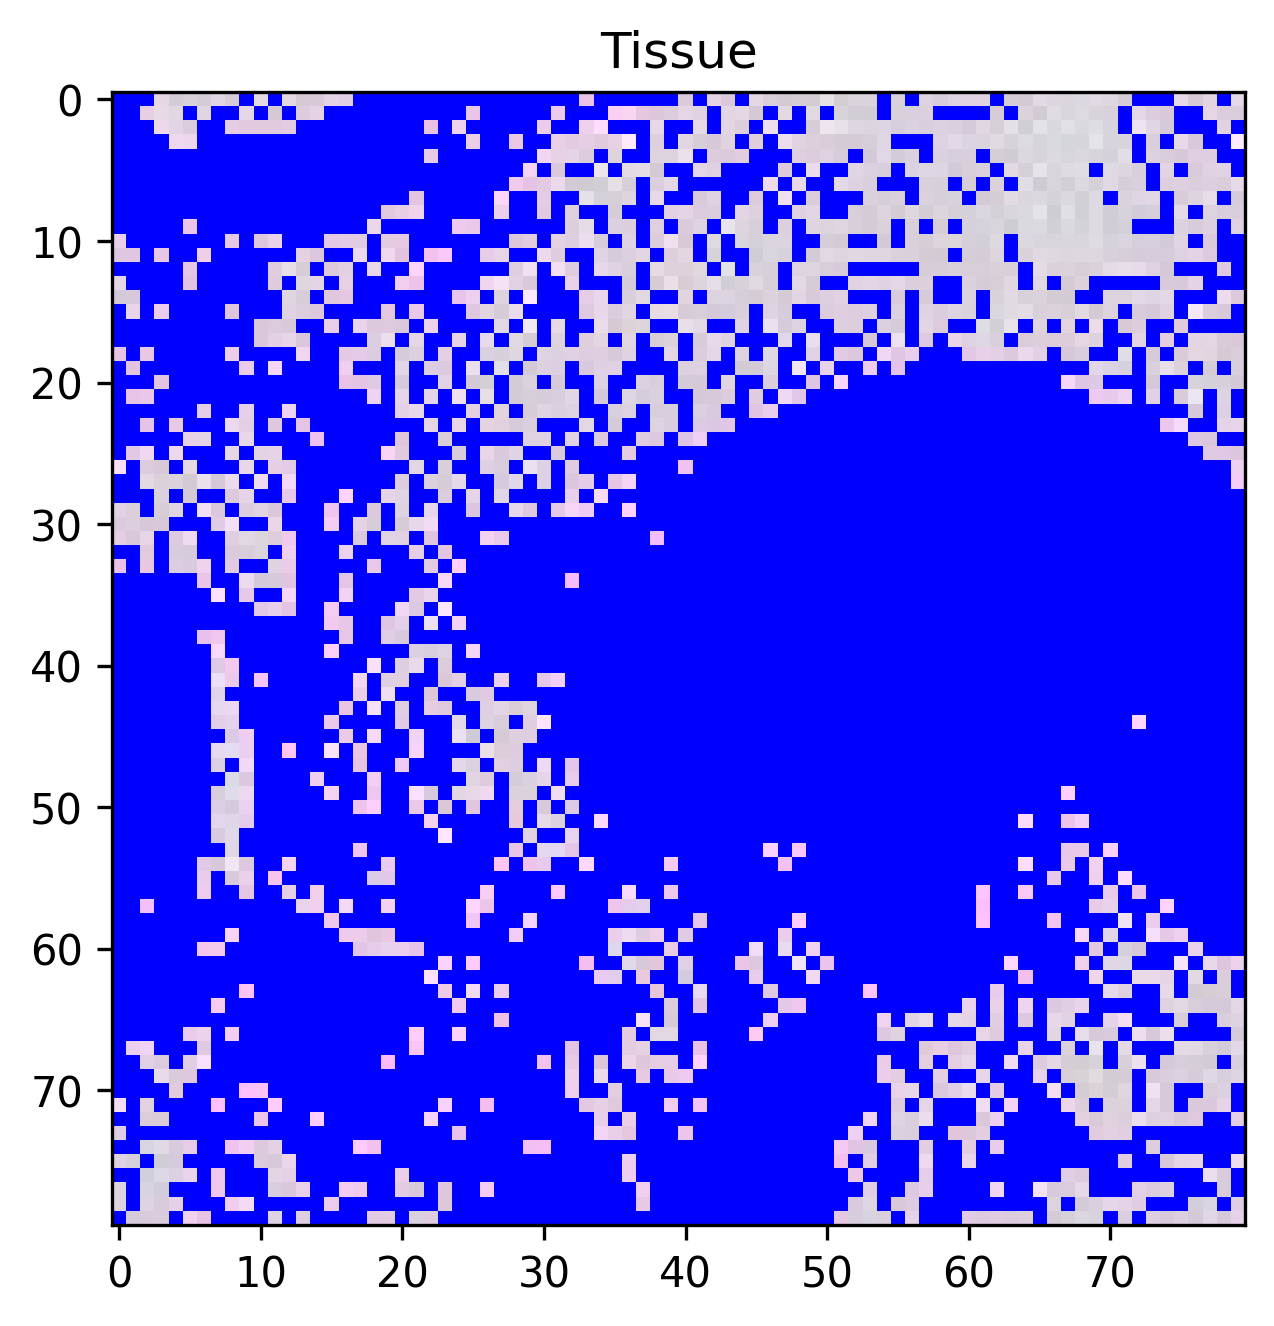

In [ ]:
tissue_pixels,bool_arr = util.find_tissue_pixels2(slide_image,intensity=0.8)
tumor_pixels = util.find_tumor_pixels(tumor_mask_image)
tissue_mask = util.apply_mask(slide_image,tissue_pixels,color=(0,0,255))
plt.figure(figsize=(5, 5), dpi=300)
plt.title("Tissue")
plt.imshow(tissue_mask)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

In [ ]:
x_test0, x_test1, x_test2, x_test3 = util.prepare_test(slide_path, 
                                                       tissue_pixels, 
                                                       level=8, 
                                                       shift_x=260, 
                                                       shift_y=80)

In [ ]:
y_pred_1 = model.predict([x_test0,x_test1,x_test2,x_test3],batch_size=256, verbose=1)

19/19 [==============================] - 20s 938ms/step


### Heatmap

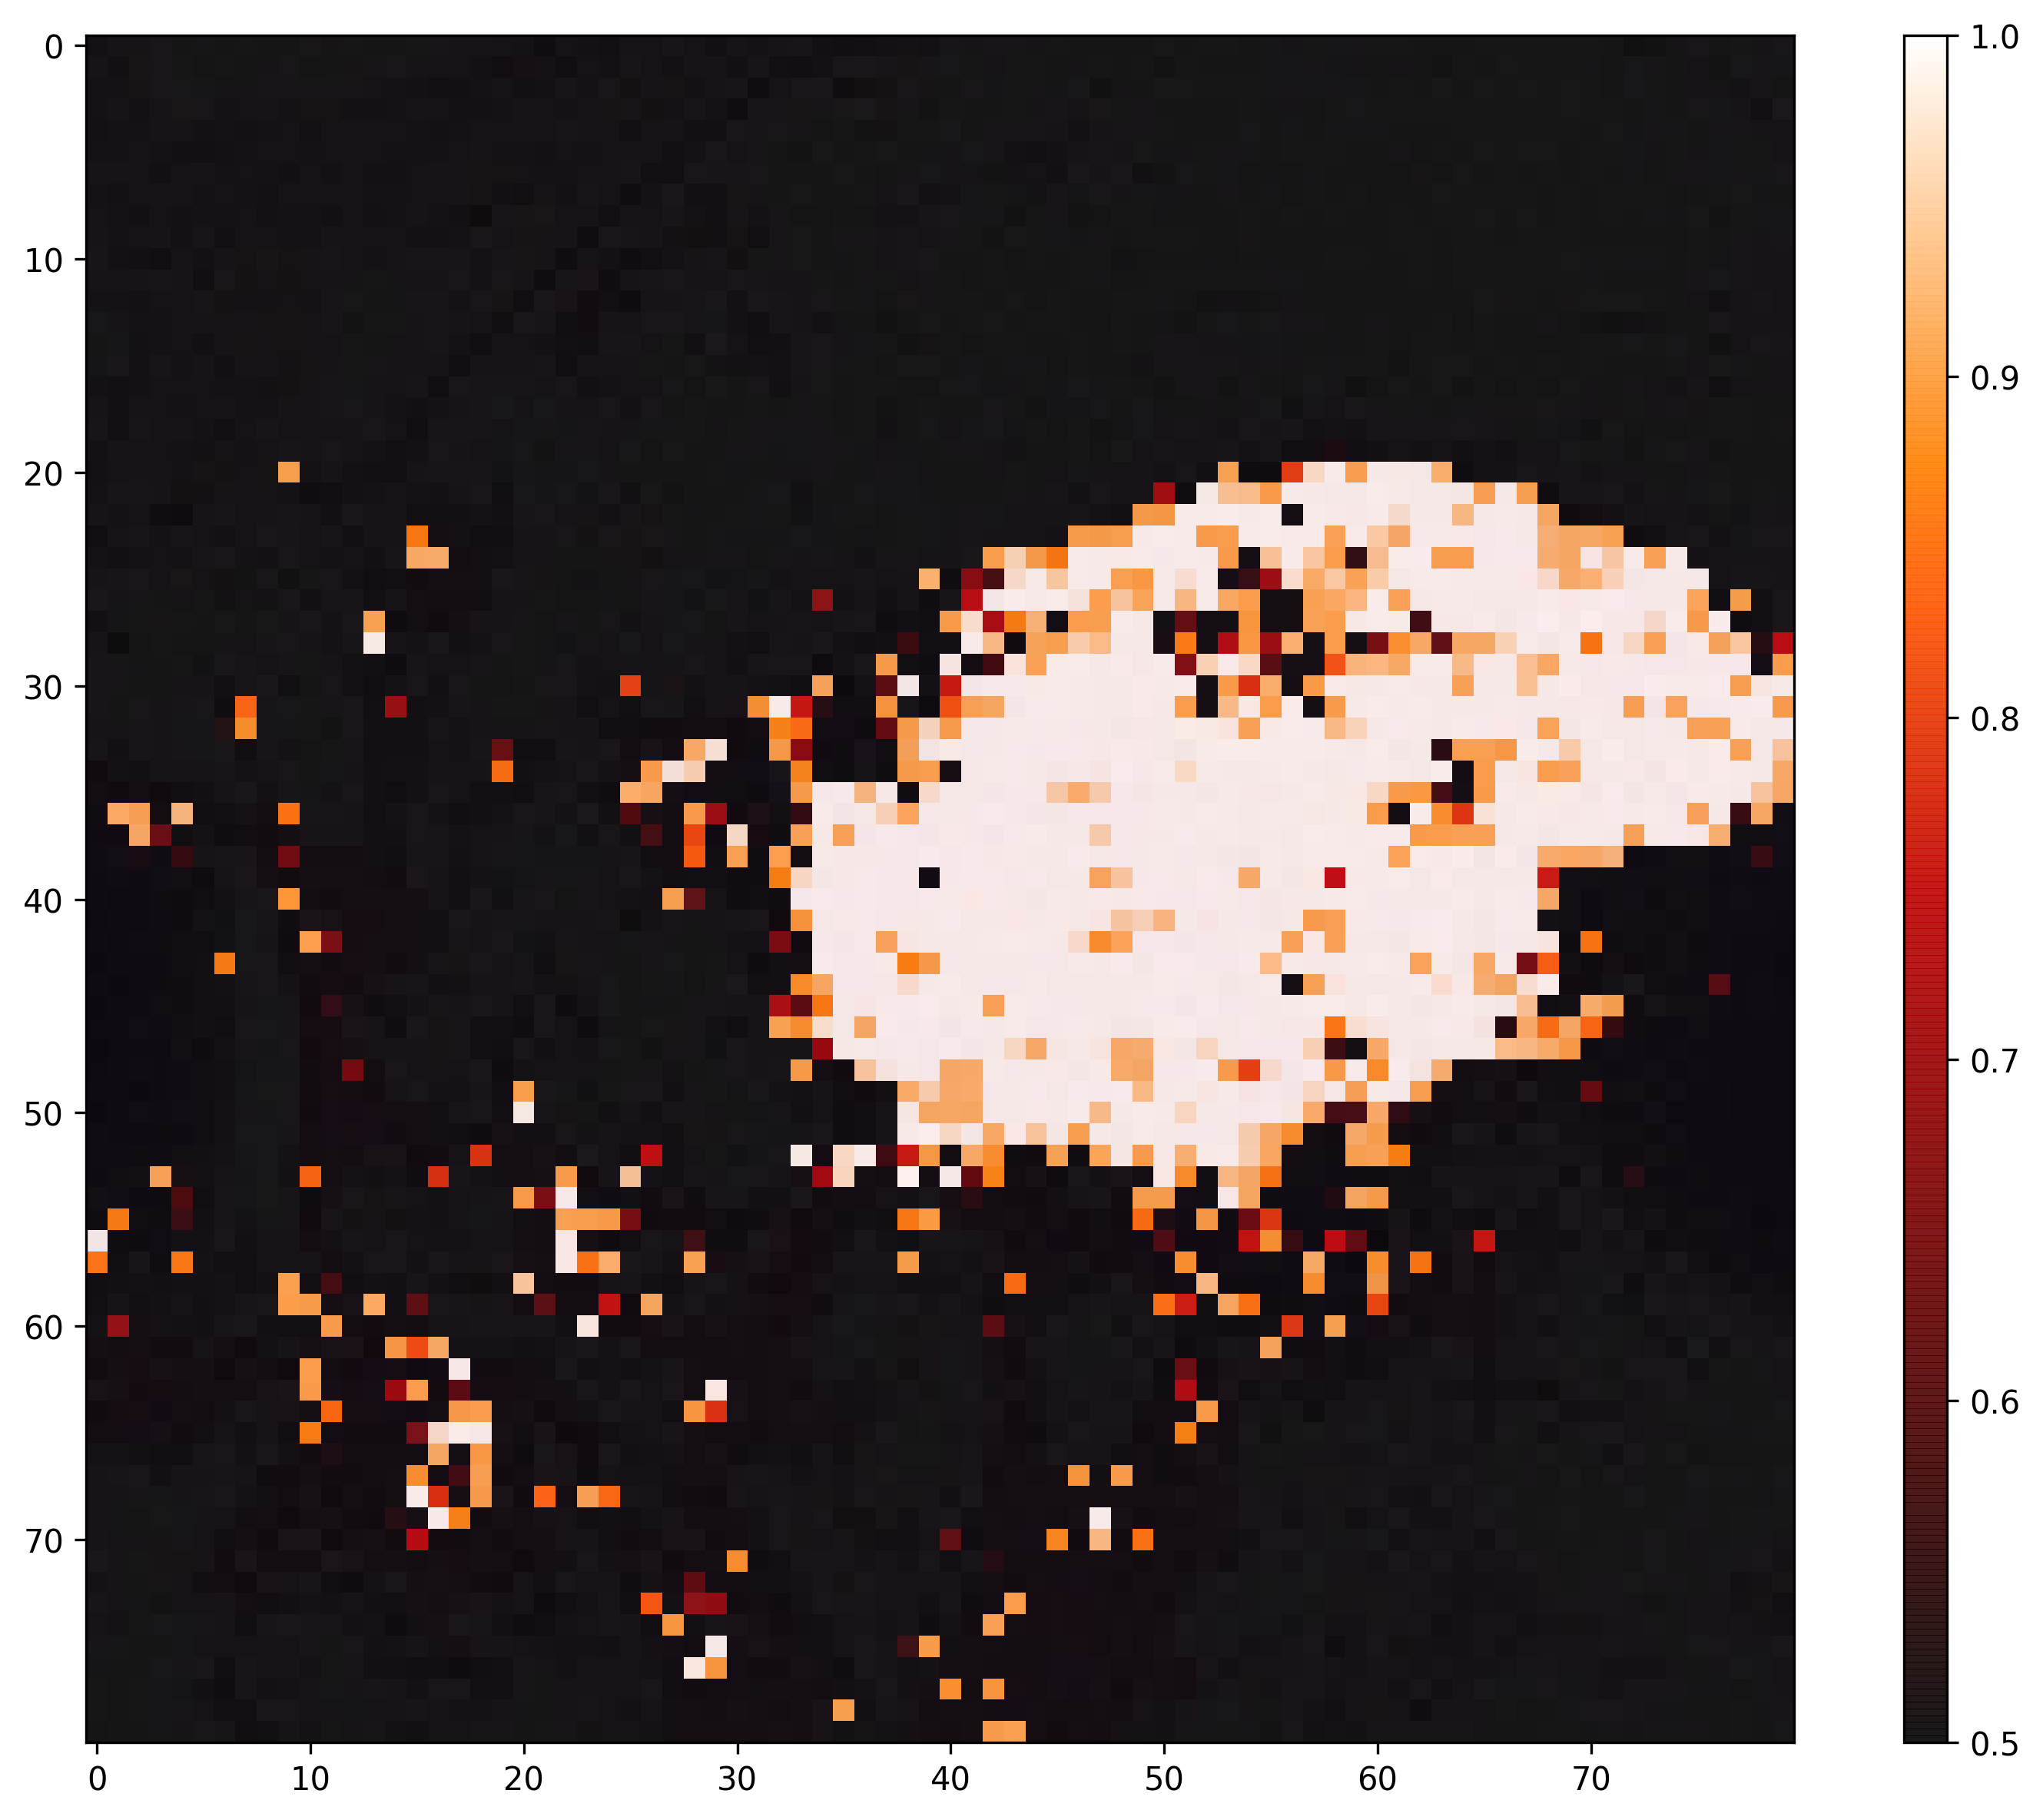

In [ ]:
tumor_mask_pred = util.plot_heat_map(y_pred_1,tissue_pixels,tumor_mask_image, slide_image)

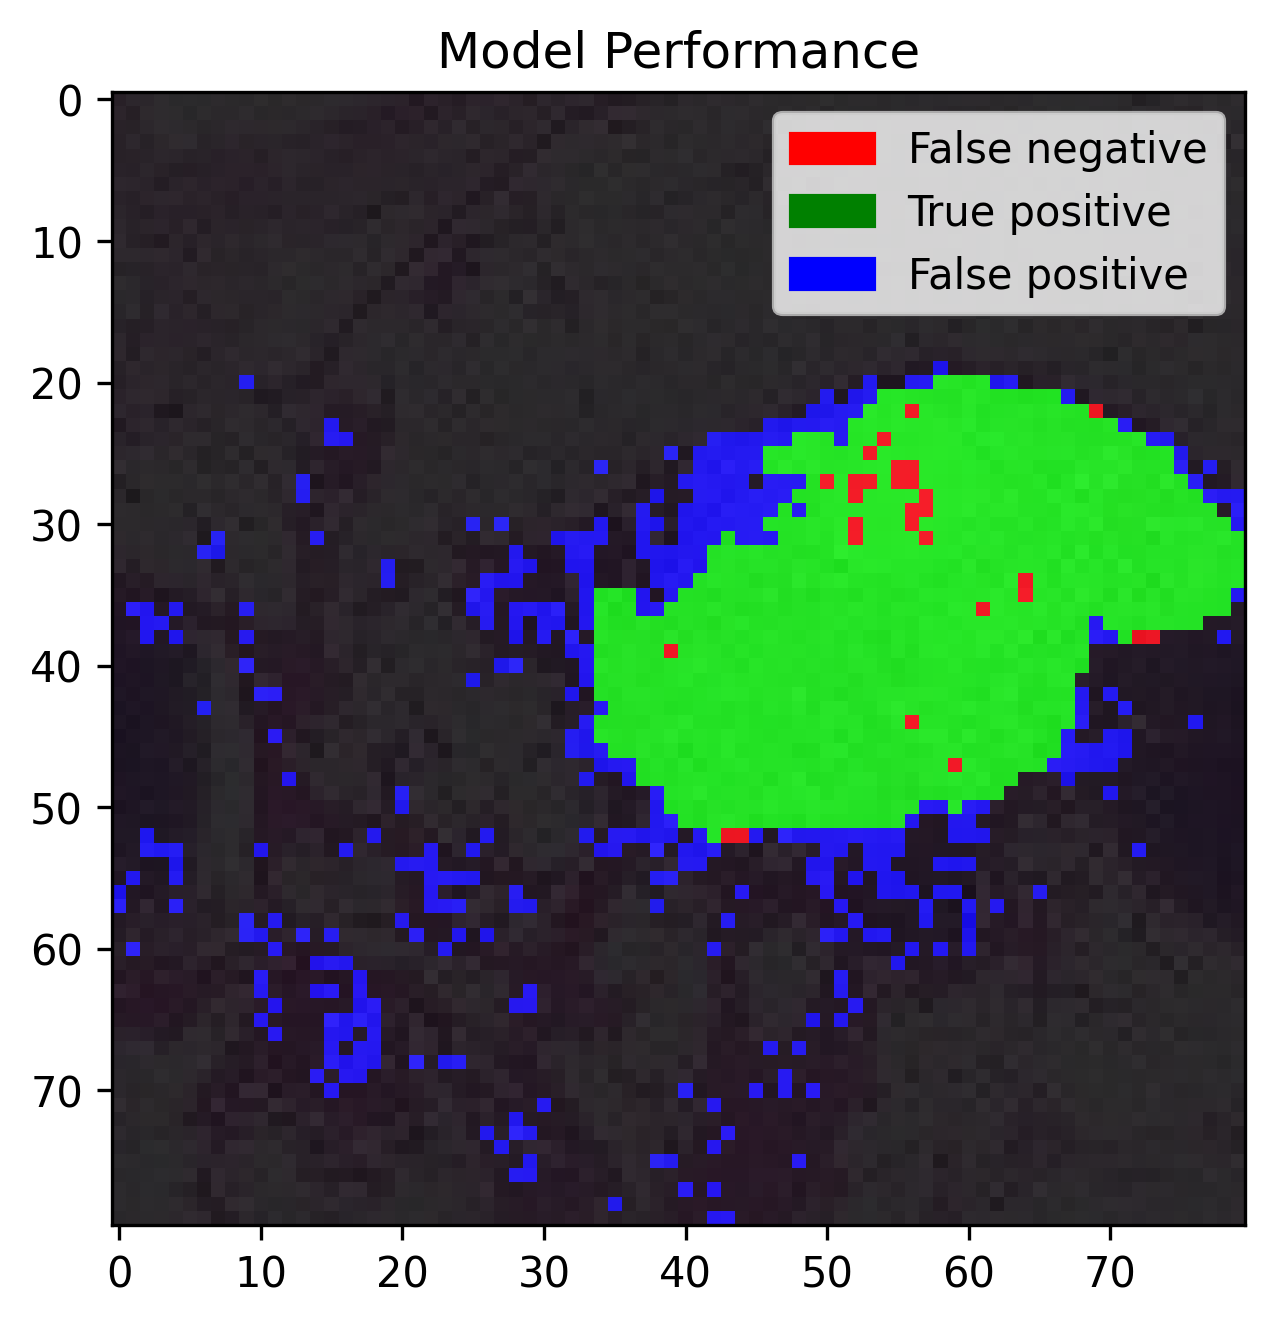

In [ ]:
util.show_performance(tumor_mask_pred, tumor_mask_image, tissue_mask, slide_image)

### Confusion Matrix

In [ ]:
util.plot_confusion_matrix(tumor_mask_image.ravel(), 
                           tumor_mask_pred.ravel(), 
                           classes=['normal', 'tumor'],
                           normalize=True,
                           title_prefix="",
                           cmap=plt.cm.Blues)

confusion_raw:
 [[5027  417]
 [  29  927]]


### F1 Score

In [ ]:
TP = 5027
FP = 417
FN = 29
F1score = TP/(TP+0.5*(FP+FN))
F1score

0.9575238095238096

### ROC curve and AUC score

In [ ]:
y_true = tumor_mask_image[bool_arr].ravel()
fpr, tpr, thresholds = roc_curve(y_true,y_pred_1)
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.show()

In [ ]:
y_pred = []
for i in y_pred_1:
  if i > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred = np.array(y_pred)

In [ ]:
roc_auc_score = roc_auc_score(y_true, y_pred)
print (roc_auc_score)

0.9287074336087358


### Precision Recall Curve

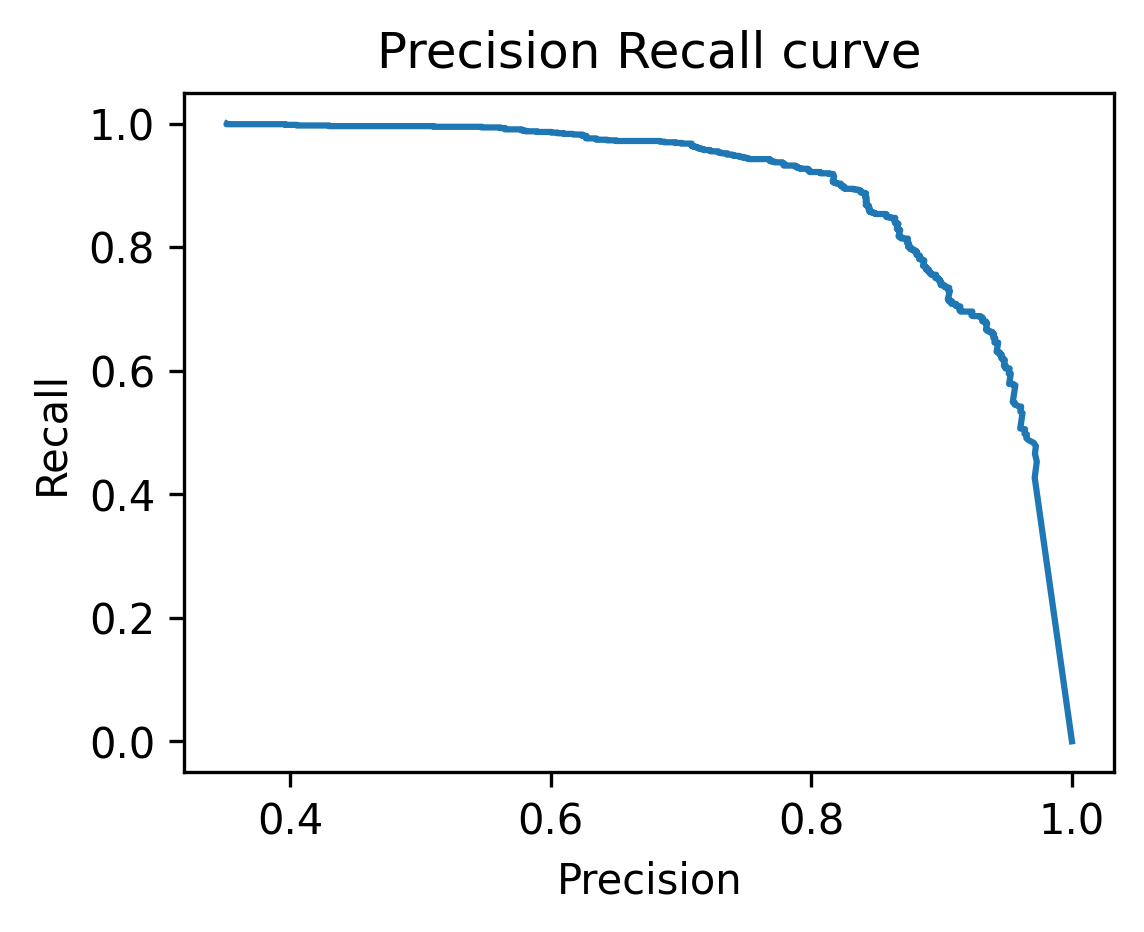

In [ ]:
from sklearn.metrics import precision_recall_curve
y_true = tumor_mask_image[bool_arr].ravel()
precision, recall, thresholds = precision_recall_curve(y_true,y_pred_1)
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(precision, recall)
plt.title('Precision Recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

### Zero One Loss

In [ ]:
from sklearn.metrics import zero_one_loss
y_true = tumor_mask_image[bool_arr].ravel()
zero_one_loss(y_true,y_pred)

0.09545259545259543

In [ ]:
%xdel x_test0
%xdel x_test1
%xdel x_test2
%xdel x_test3
import gc
gc.collect()

38181

## 4.4 Test on New TIF 

In [ ]:
slide_path = 'tumor_091.tif' 
tumor_mask_path = 'tumor_091_mask.tif' 

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

if not os.path.exists(slide_path):
  !curl -O $slide_url

if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide_path = 'tumor_091.tif'
tumor_mask_path = "tumor_091_mask.tif"
slide = open_slide(slide_path)
tumor_mask_slide = open_slide(tumor_mask_path)
level = 7

In [ ]:
slide_image = util.read_slide(slide,
                         x=0,
                         y=0,
                         level=level,
                         width=slide.level_dimensions[level][0],
                         height=slide.level_dimensions[level][1])
tumor_mask_image = util.read_slide(tumor_mask_slide,
                              x=0,
                              y=0,
                              level=level,
                              width=slide.level_dimensions[level][0],
                              height=slide.level_dimensions[level][1])[:, :, 0]

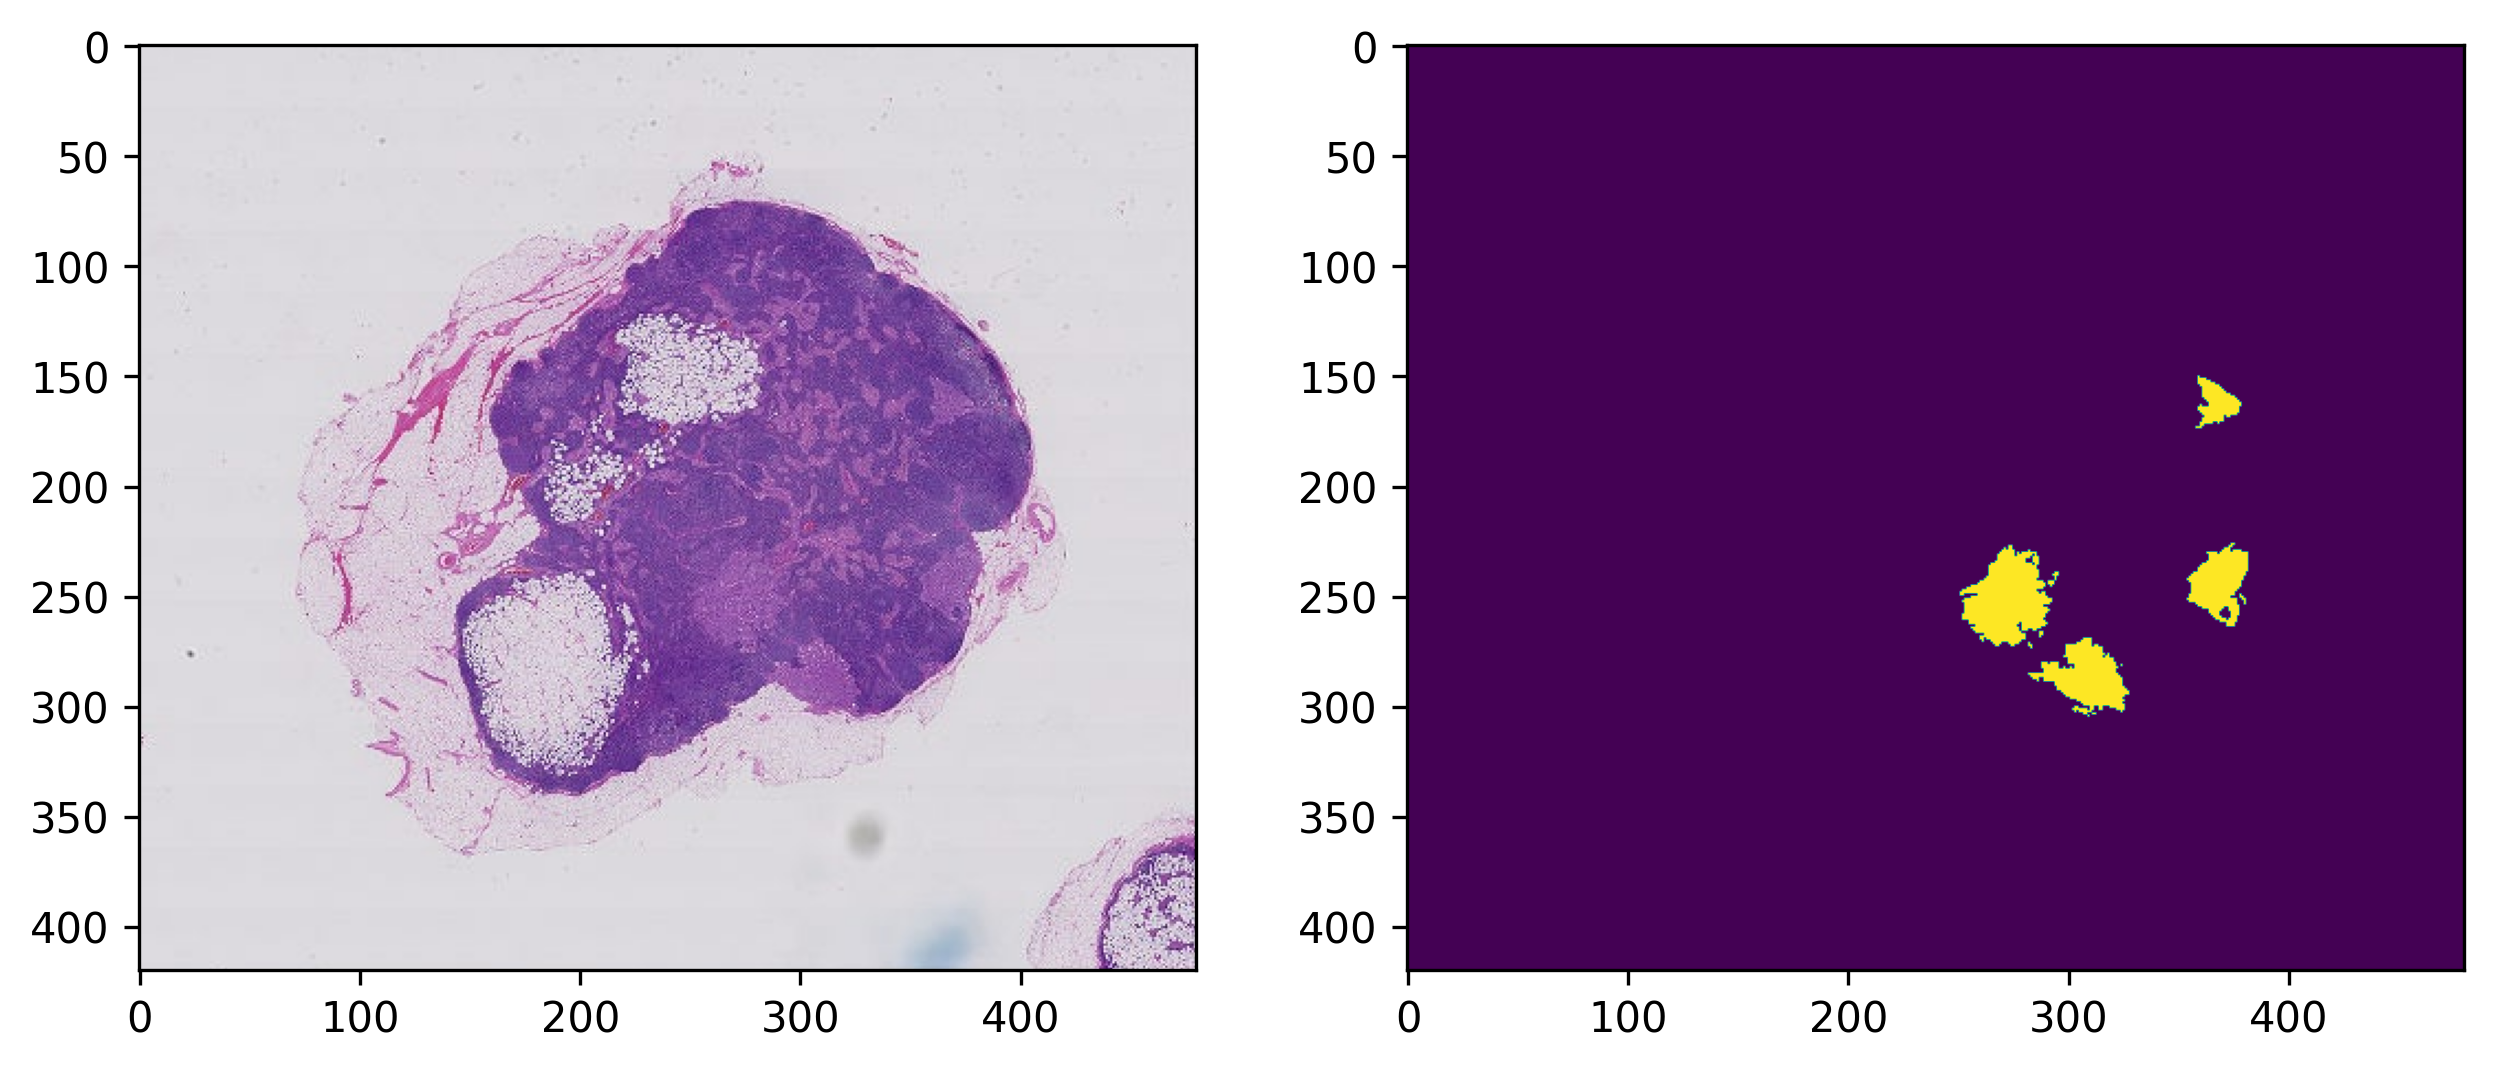

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=300)
ax[0].imshow(slide_image)
ax[1].imshow(tumor_mask_image)
plt.show()

In [ ]:
slide_image = util.read_slide(slide,
                         x=300*2**level,
                         y=250*2**level,
                         level=level,
                         width=64,
                         height=64)
tumor_mask_image = util.read_slide(tumor_mask_slide,
                              x=300*2**level,
                              y=250*2**level,
                              level=level,
                              width=64,
                              height=64)[:, :, 0]

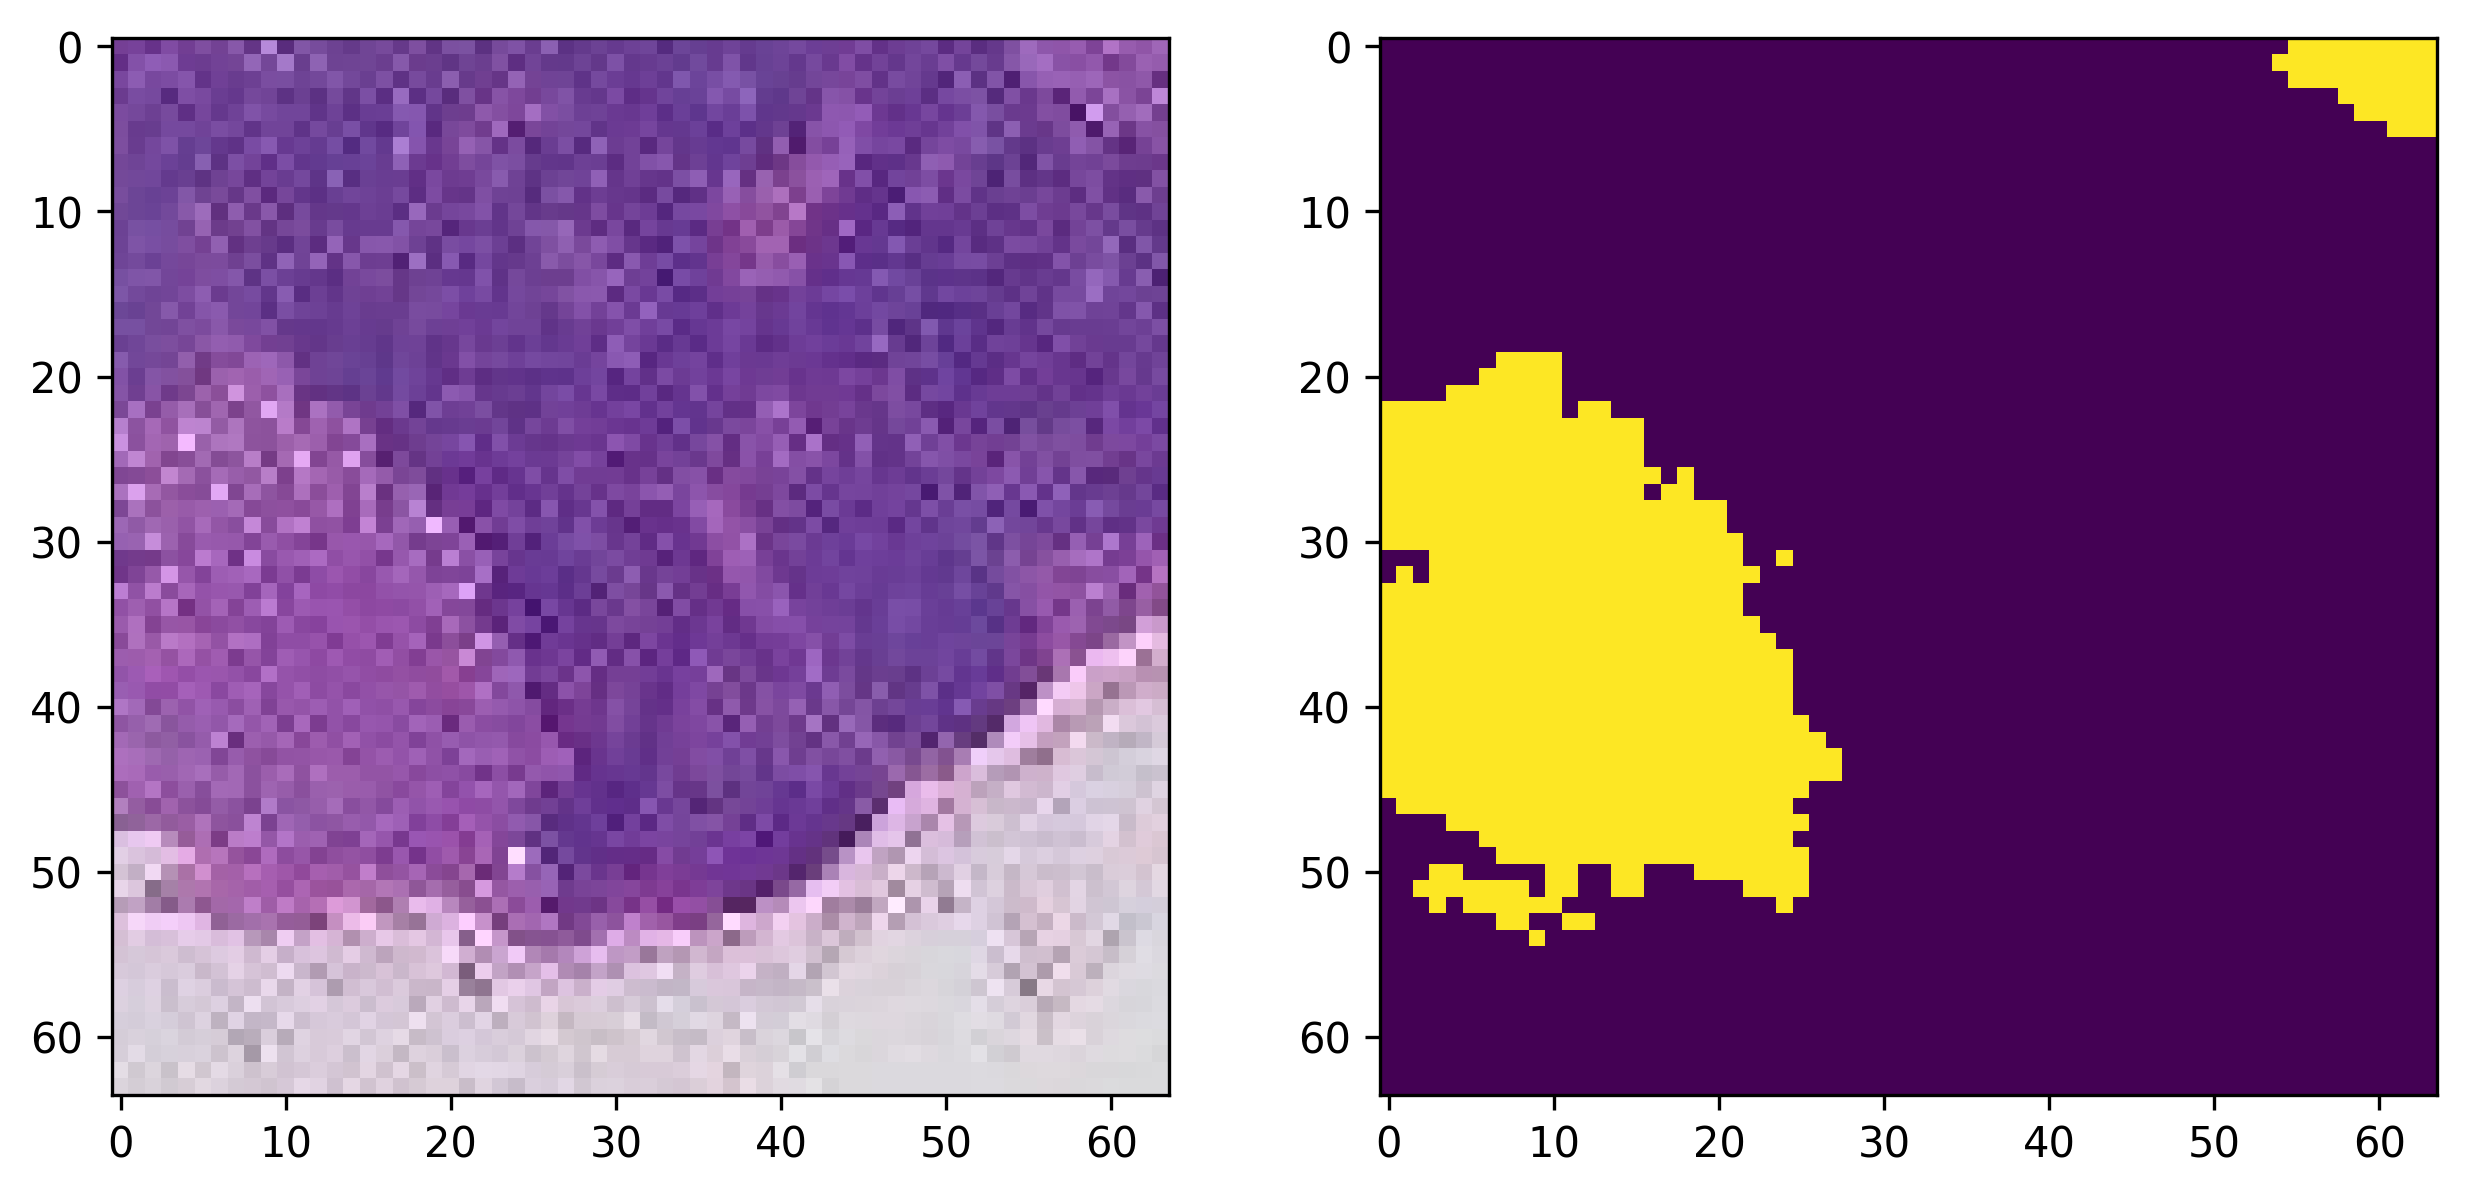

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=300)

ax[0].imshow(slide_image)
ax[1].imshow(tumor_mask_image)
plt.show()

In [ ]:
tissue_pixels,bool_arr = util.find_tissue_pixels2(slide_image,intensity=0.8)
tumor_pixels = util.find_tumor_pixels(tumor_mask_image)
tissue_mask = util.apply_mask(slide_image,tissue_pixels,color=(0,0,255))
plt.figure(figsize=(5, 5), dpi=300)
plt.title("Tissue")
plt.imshow(tissue_mask)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

3580 tissue_pixels pixels (87.4 percent of the image)


In [ ]:
x_test0, x_test1, x_test2, x_test3 = util.prepare_test(slide_path, tissue_pixels, level=7, shift_x=300, shift_y=250)

In [ ]:
y_pred_test = model.predict([x_test0,x_test1,x_test2,x_test3],batch_size=256, verbose=1)

14/14 [==============================] - 45s 1s/step


### Heatmap

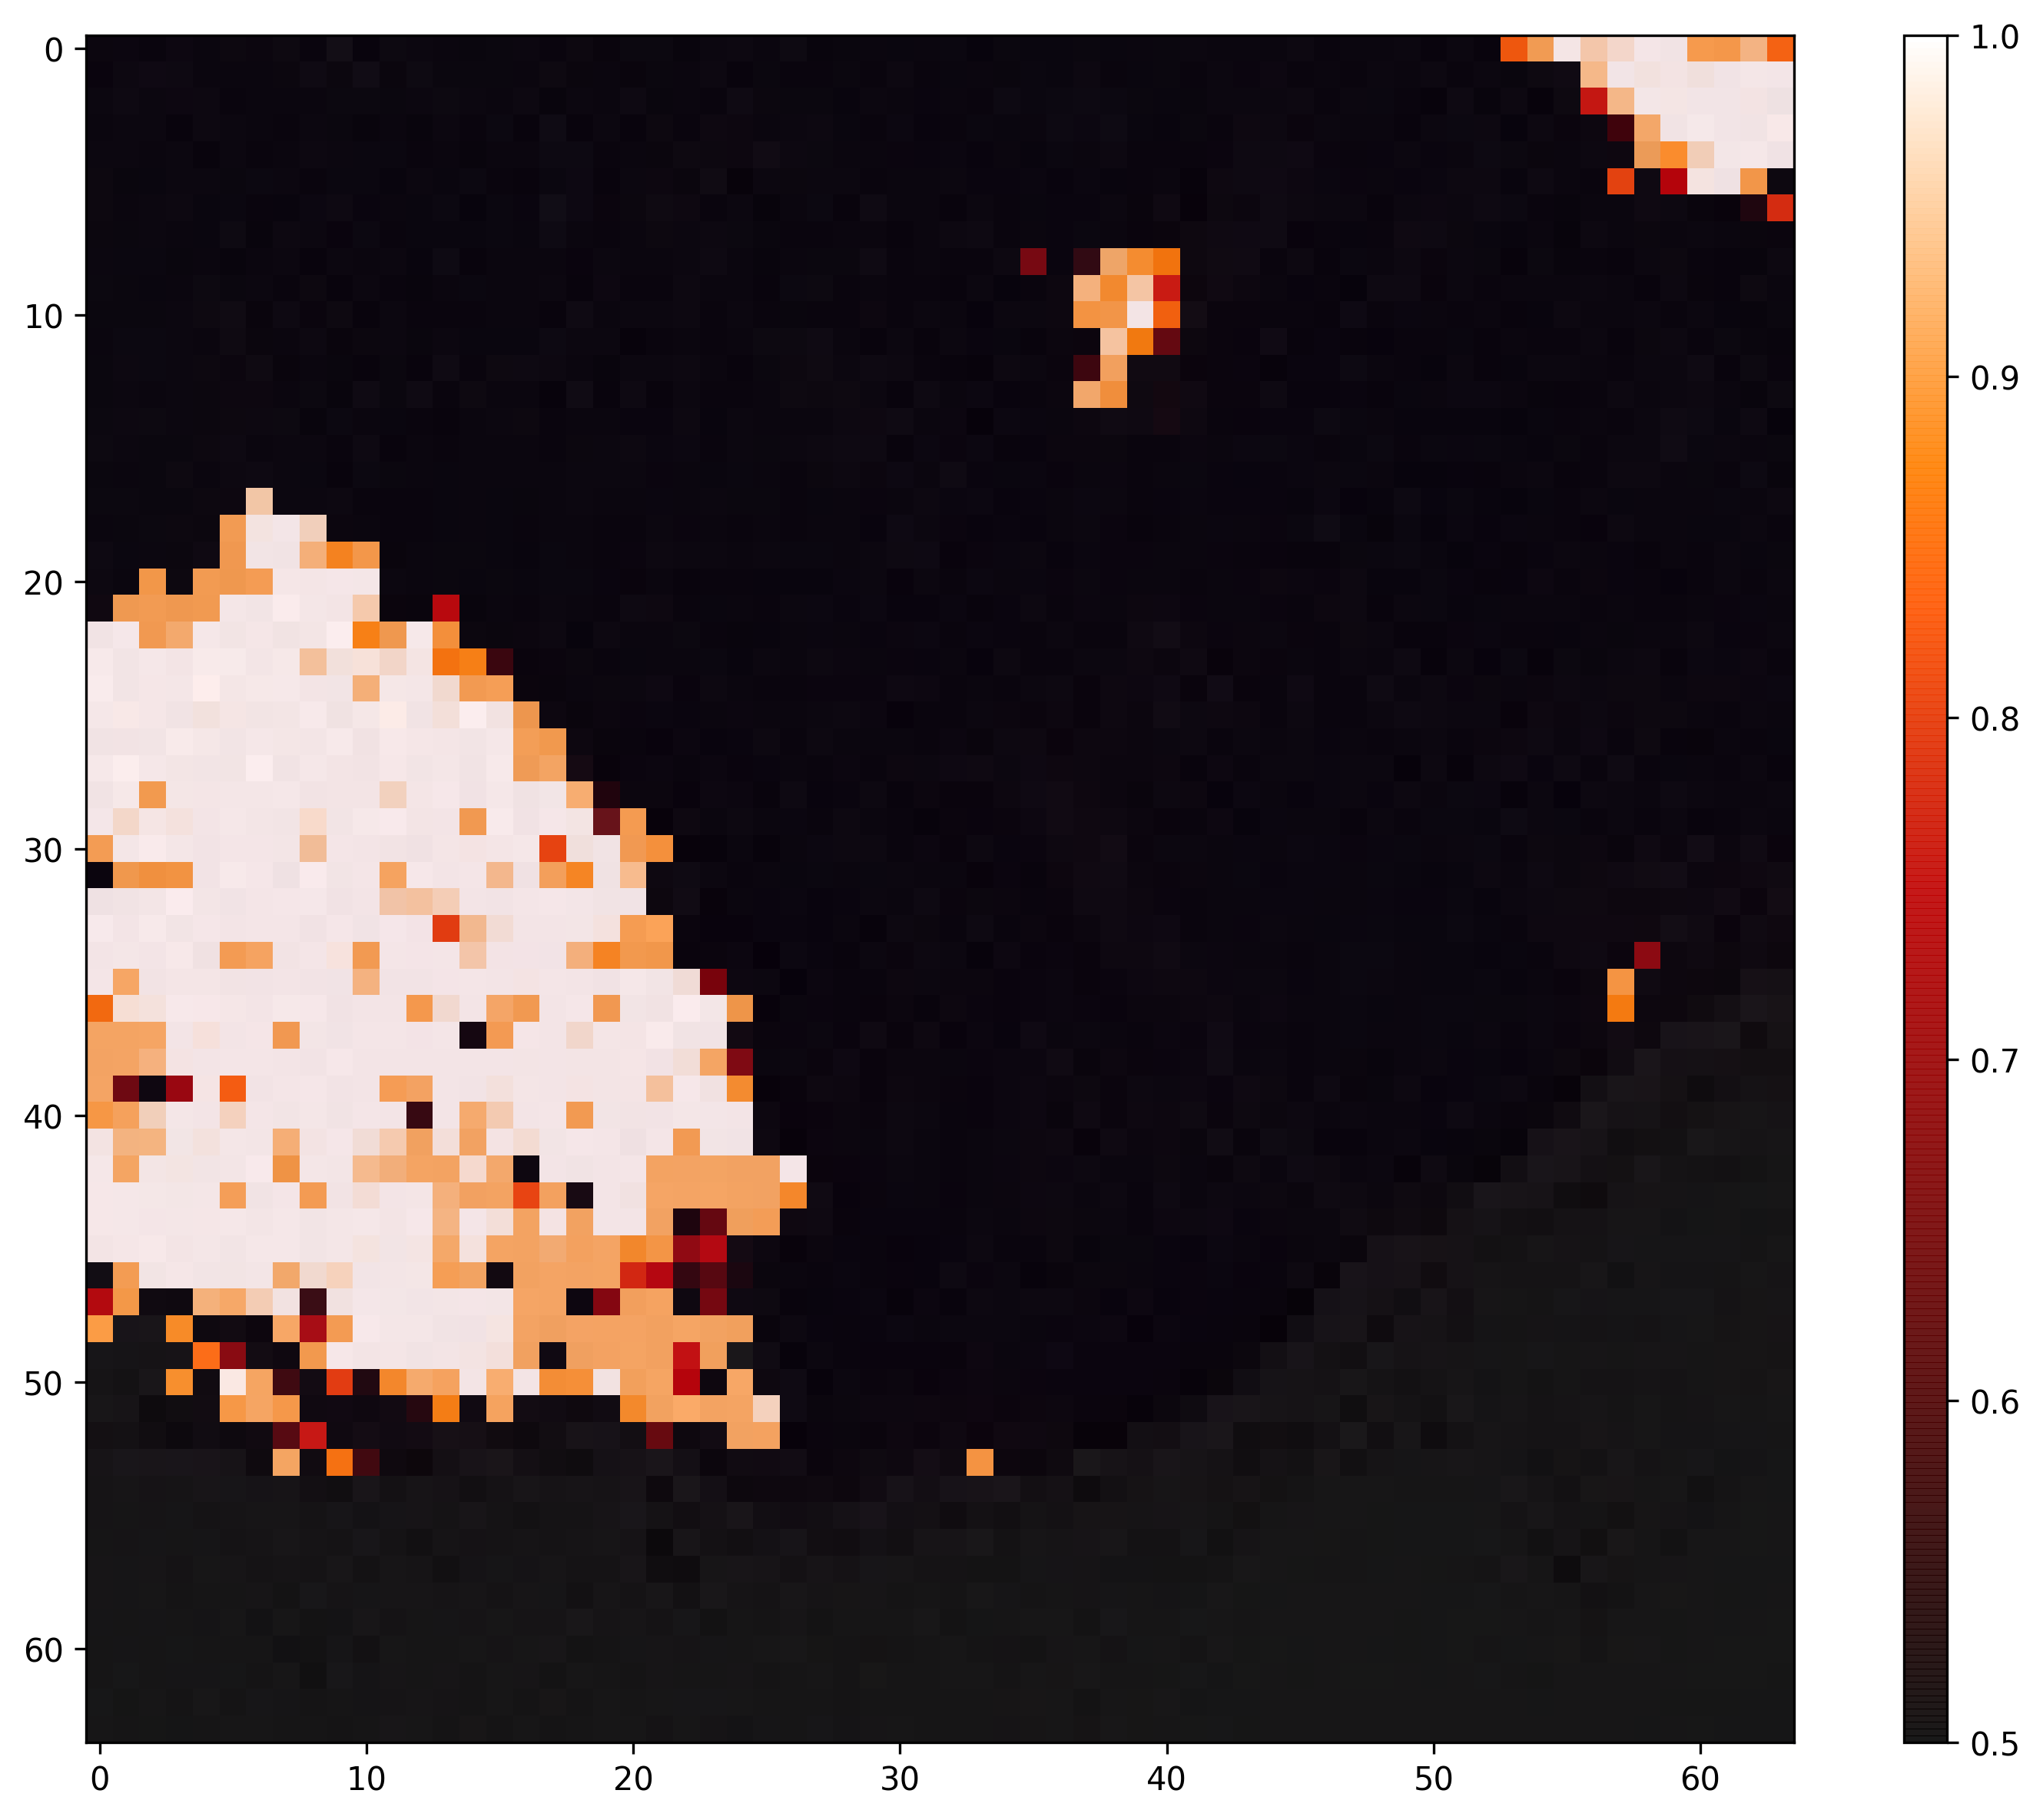

In [ ]:
tumor_mask_pred = util.plot_heat_map(y_pred_test,tissue_pixels,tumor_mask_image,slide_image)

In [ ]:
util.show_performance(tumor_mask_pred, tumor_mask_image, tissue_mask, slide_image)

### Confusion Matrix

confusion_raw:
 [[3295   90]
 [  44  667]]


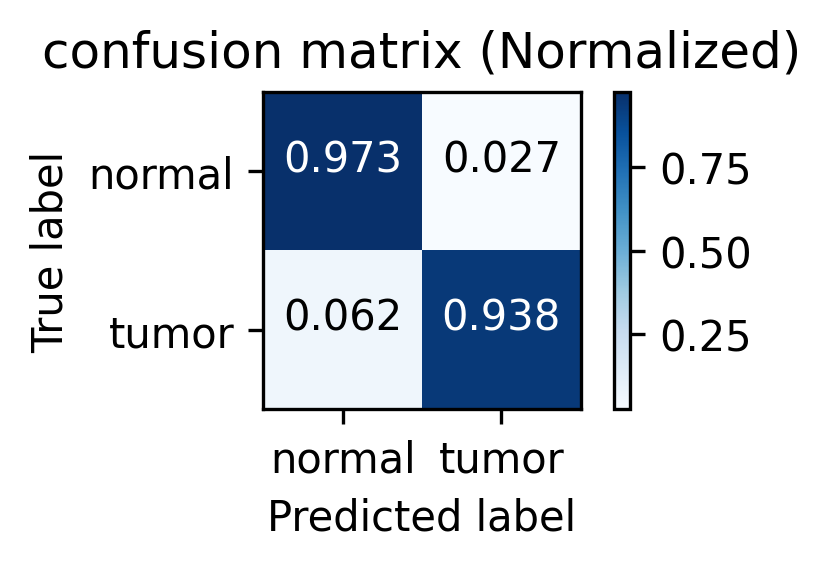

In [ ]:
util.plot_confusion_matrix(tumor_mask_image.ravel(), 
                      tumor_mask_pred.ravel(), 
                      classes=['normal', 'tumor'],
                      normalize=True,
                      title_prefix="",
                      cmap=plt.cm.Blues)

### F1 Score

In [ ]:
TP = 3295
FP = 90
FN = 44
F1score = TP/(TP+0.5*(FP+FN))
F1score

0.9800713860797144

### ROC curve and AUC score

In [ ]:
fpr, tpr, thresholds = roc_curve(tumor_mask_image[bool_arr].ravel(),y_pred_test)
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.show()

In [ ]:
roc_auc_score(
    tumor_mask_image[bool_arr].ravel(), y_pred_test)

0.9916037689551945

### Precision Recall curve

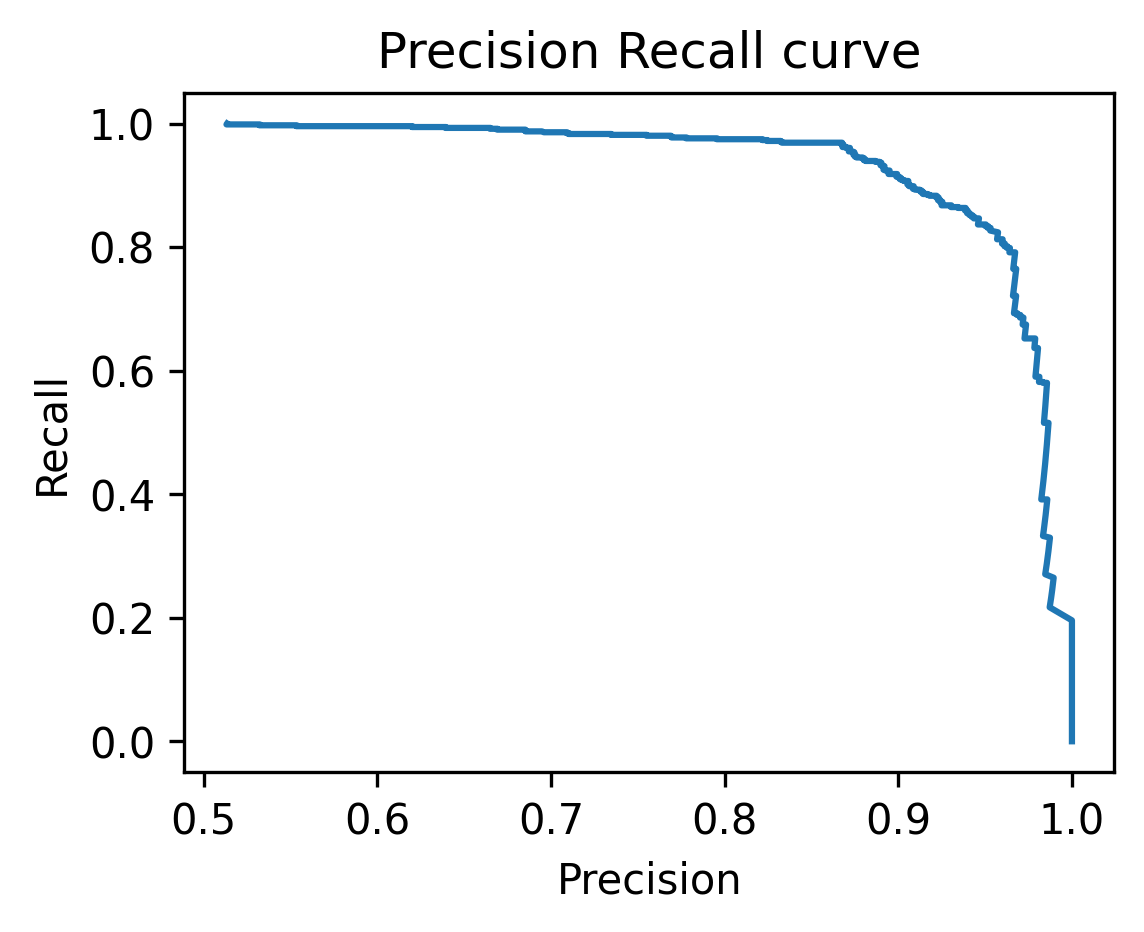

In [ ]:
from sklearn.metrics import precision_recall_curve
y_true = tumor_mask_image[bool_arr].ravel()
precision, recall, thresholds = precision_recall_curve(y_true,y_pred_test)
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(precision, recall)
plt.title('Precision Recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

### Zero One Loss

In [ ]:
y_pred = []
for i in y_pred_test:
  if i > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import zero_one_loss
y_true = tumor_mask_image[bool_arr].ravel()
zero_one_loss(y_true,y_pred)

0.03715083798882679

In [ ]:
%xdel x_test0
%xdel x_test1
%xdel x_test2
%xdel x_test3
import gc
gc.collect()

98025